In [ ]:
import time
start_time = time.perf_counter()

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
import sys
import umap

from openTSNE import TSNE as otsne
from scipy import stats
from scipy.cluster.hierarchy import linkage
from scipy.stats import yeojohnson as yj
from sklearn.cluster import AgglomerativeClustering as agc
from sklearn.cluster import DBSCAN, KMeans
from sklearn.decomposition import PCA, SparsePCA
from sklearn.feature_selection import chi2
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score as sil
from sklearn.mixture import GaussianMixture as gmm
from sklearn.preprocessing import MinMaxScaler as minmax

np.set_printoptions(suppress=True)
np.set_printoptions(threshold=sys.maxsize)
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
sns.set(font_scale=1.1)
sns.set_style('darkgrid')
%matplotlib inline

### Unsupervised Learning Capstone: Movie Clustering
#### Jared Pollack
#### August 7, 2020
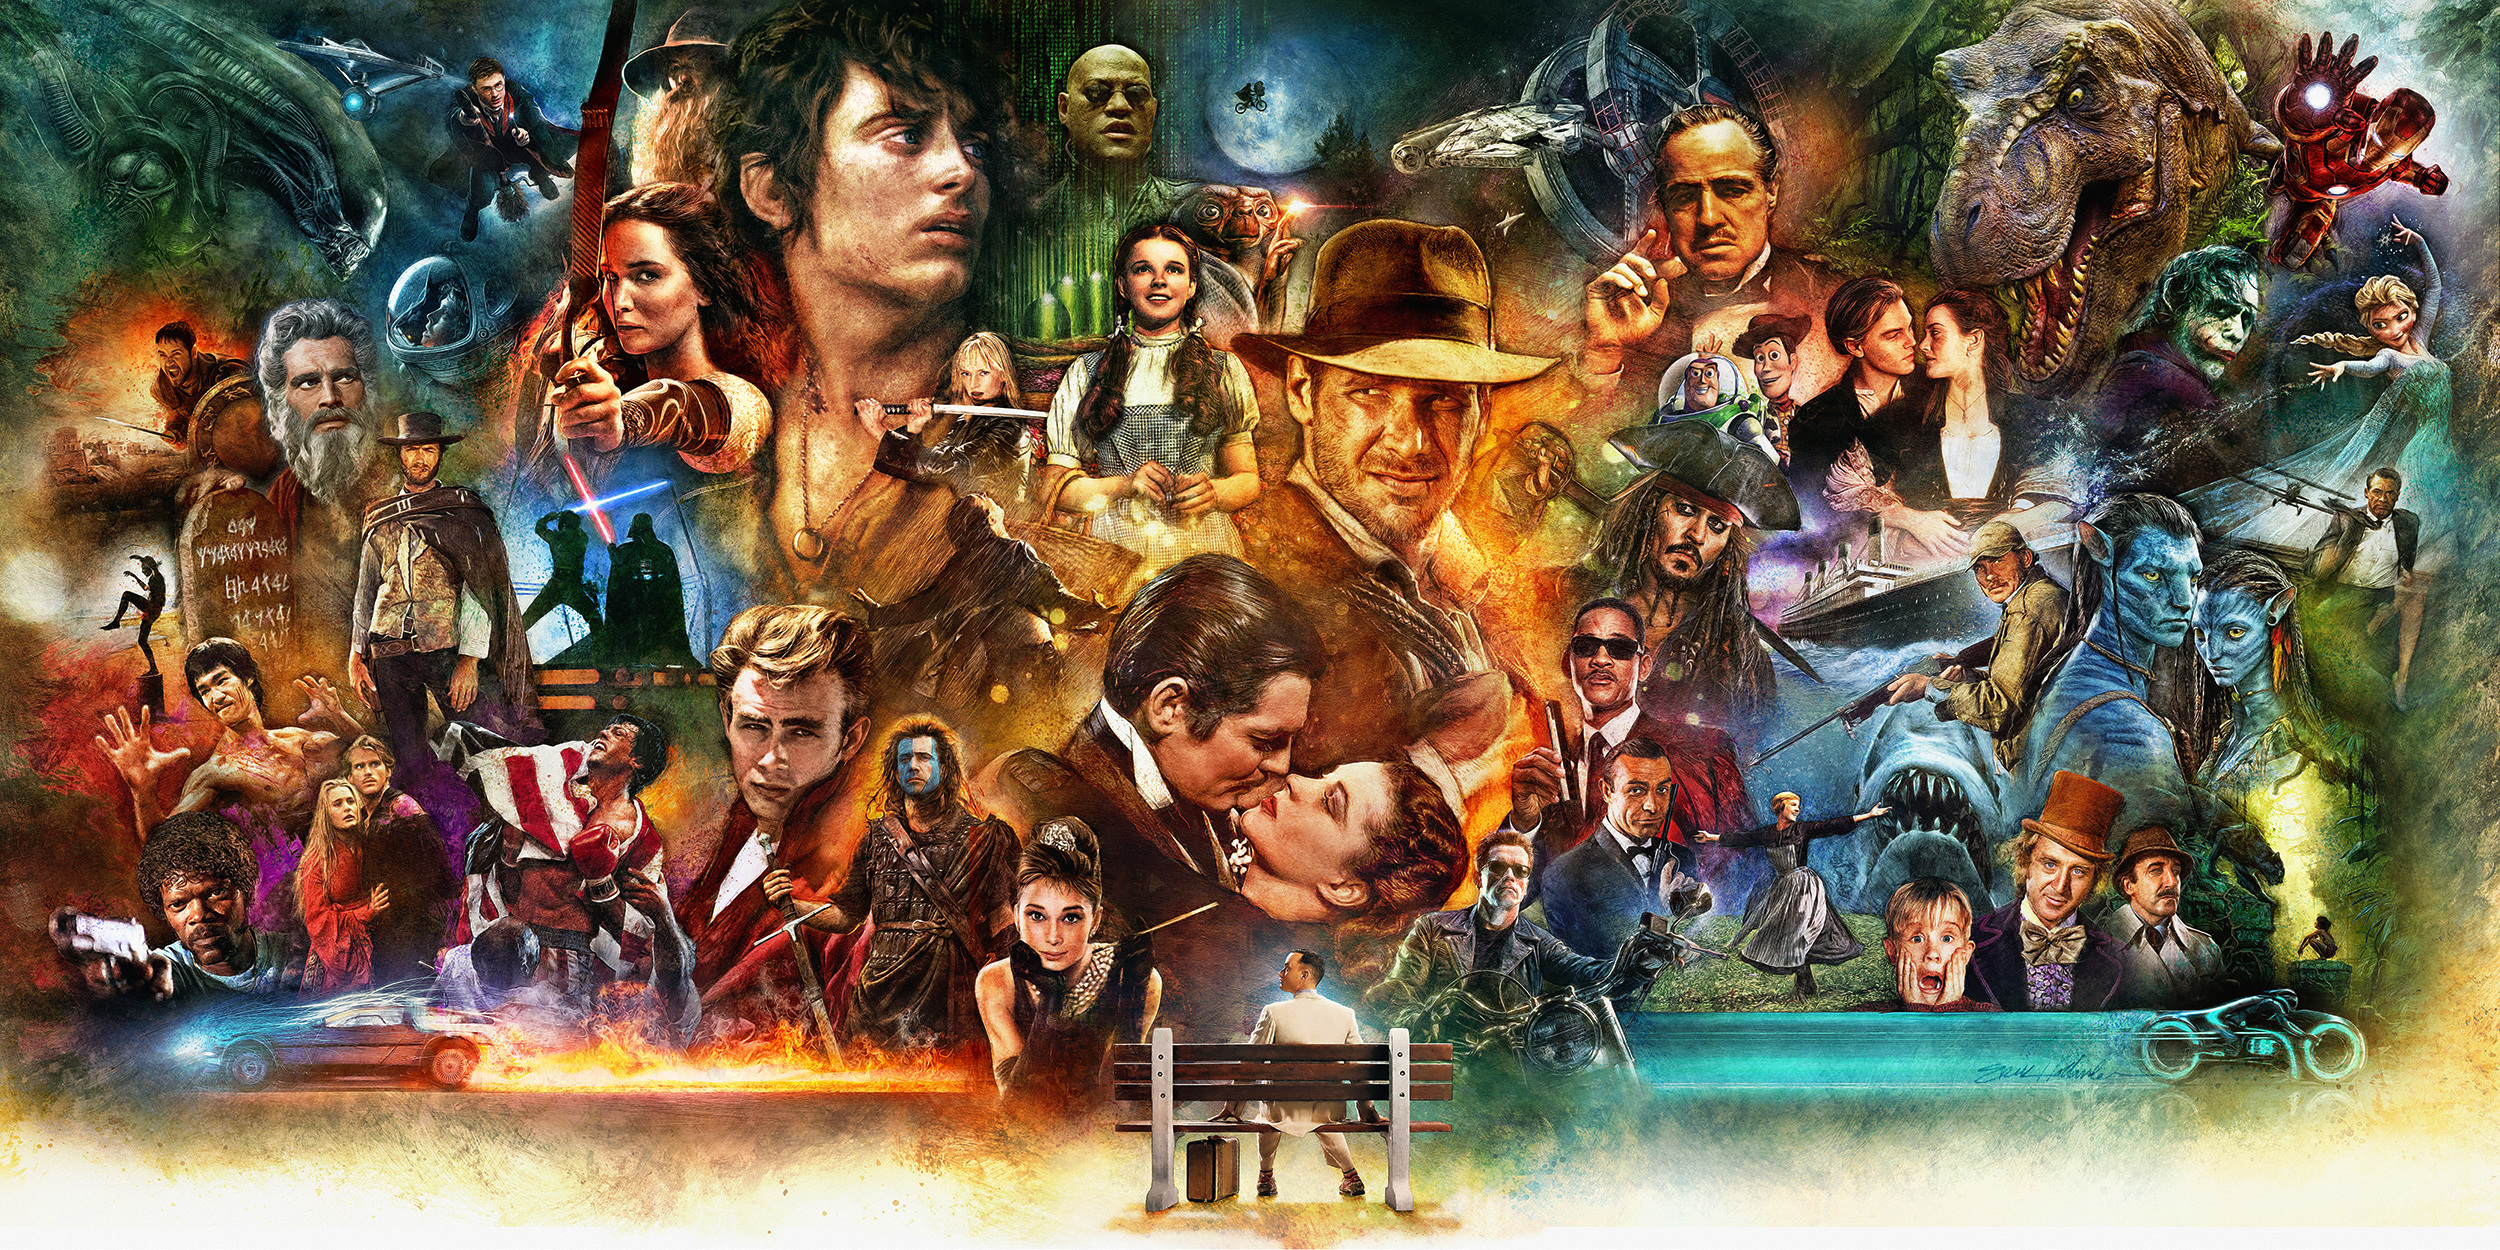

## Introduction

* Decisions, decisions, decisions... about what to watch
* Recommendation engines

* Collaborative filtering - considers ratings from other users
* Content-based filtering - considers information about the movie
* Hybrid recommender systems - uses both filtering types and/or other methods

Life used to be so simple, right? We used to just turn on the TV and flip through channels to see what was on. If you found something you liked, great; if not, turn it off and read a book. Now, everything is 'on-demand'. For the most part, you can watch anything, anytime - assuming you have an Internet connection, a Netflix account, and a valid form of payment.
So you've set up recurring monthly payments, and now it's time to get your money's worth. That means, you need stuff to watch.
Recommendation engines try to predict how a customer will rate show by collaborative and content-based filtering information.

#### Movie data set: https://www.kaggle.com/danielgrijalvas/movies

* (kaggle user) "scraped from IMDb using Python."
* 6820 movies spanning 1986 - 2016
* 25% of rows missing budget values
* 5,280 samples for cluster analysis

In [ ]:
mov_csv = pd.read_csv('https://github.com/jp213/thinkful/raw/master/movies.csv',
                      encoding='latin1')
mov = mov_csv[(mov_csv != 0).all(1)]
mov.reset_index(drop=True, inplace=True)
mov.info()

## Exploratory Data Analysis

### Numerical Variables

* Movie budget - estimated production cost

* Box Office Gross - gross earnings

* Runtime - duration of the film

* Score - IMDb user rating (10-point scale)

* Votes - numer of user ratings submitted

In [ ]:
ybudget,_ = yj(mov.budget)
mov = mov.copy()
mov['ybudget'] = ybudget

yruntime,_ = yj(mov.runtime)
mov['yruntime'] = yruntime

plt.figure(figsize=(18, 5))
plt.subplot(1, 2, 1)
ax = sns.distplot(mov.gross, kde=False, bins=50)
ax.set_title('Gross Distribution', fontsize=13.6)
ax.set(xlabel='Box Office Gross (USD)')
xlabels = ['$' + '{:,.0f}'.format(x) + 'M' for x in ax.get_xticks()/1000000]
ax.set_xticklabels(xlabels)
print('gross', stats.describe(mov.gross), '\n')

ygross,_ = yj(mov.gross)
mov['ygross'] = ygross

plt.subplot(1, 2, 2)
ax = sns.distplot(mov.ygross, bins=50)
ax.set_title('Yeo-Johnson Gross Distribution', fontsize=13.6)
plt.show()

print('ygross:', stats.describe(mov.ygross), '\n')

In [ ]:
yruntime,_ = yj(mov.runtime)
mov['yruntime'] = yruntime

rnums = mov.runtime[mov.runtime > 195]
rdf = pd.DataFrame(rnums, columns=['runtime'])
mm = minmax(feature_range=(196, 200))
rdfs = mm.fit_transform(rdf)
rdft = pd.DataFrame(rdfs, columns=['runtime'])

mov.loc[[317], 'runtime'] = rdft.runtime[0]
mov.loc[[947], 'runtime'] = rdft.runtime[1]
mov.loc[[1066], 'runtime'] = rdft.runtime[2]
mov.loc[[1265], 'runtime'] = rdft.runtime[3]
mov.loc[[1797], 'runtime'] = rdft.runtime[0]
mov.loc[[2631], 'runtime'] = rdft.runtime[1]
mov.loc[[2905], 'runtime'] = rdft.runtime[2]
mov.loc[[3017], 'runtime'] = rdft.runtime[3]

ysruntime,_ = yj(mov.runtime)
mov['ysruntime'] = ysruntime

yscore,_ = yj(mov.score)
mov['yscore'] = yscore

yvotes,_ = yj(mov.votes)
mov['yvotes'] = yvotes

### Paranormal Profits

***Paranormal Activity***
- Budget: $15,000

- Gross: $107,918,810

- Earned over 7,000 times budget

***The Blair Witch Project***
- Budget: $60,000

- Gross: $140,539,099

- Earned over 2,300 times budget

#### Net Profit Ratio - gross divided by budget

* created variable
* purpose: mimic Return on Investment (ROI)

In [ ]:
mov['npr'] = mov.gross/mov.budget
print('npr', stats.describe(mov.npr), '\n')

plt.figure(figsize=(14, 5))
ax = sns.distplot(mov.npr, kde=False, bins=100)
ax.set_title('Net Profit Ratio Distribution', fontsize=13.6)
ax.set(xlabel='Percentage Return on Investment')
xlabels = ['{:,.0f}'.format(x) + '%' for x in ax.get_xticks()]
ax.set_xticklabels(xlabels)
plt.show()

In [ ]:
# scaling top 4 values between 300 and 400 to minimize effect of outliers
inums = mov.npr[mov.npr > 400]
ndf = pd.DataFrame(inums, columns=['npr'])
mm = minmax(feature_range=(300, 400))
ndfs = mm.fit_transform(ndf)
ndft = pd.DataFrame(ndfs, columns=['npr'])

mov.loc[[166], 'npr'] = ndft.npr[0]
mov.loc[[1710], 'npr'] = ndft.npr[1]
mov.loc[[2223], 'npr'] = ndft.npr[2]
mov.loc[[3627], 'npr'] = ndft.npr[3]

#### Top 4 values scaled between 300 - 400

In [ ]:
print('npr', stats.describe(mov.npr), '\n')
plt.figure(figsize=(14, 5))
ax = sns.distplot(mov.npr, kde=False, bins=100)
ax.set_title('Net Profit Ratio Distribution After Scaling Top 4',
             fontsize=13.6)
ax.set(xlabel='Percentage Return on Investment')
xlabels = ['{:,.0f}'.format(x) + '%' for x in ax.get_xticks()]
ax.set_xticklabels(xlabels)
plt.show()

### Categorical/Nominal Variables

* Production Company
* Country
* Director
* Genre
* Rating
* Title
* Lead Actor
* Writer

In [ ]:
print('Count of Unique Values:\n')
print('Production Companies:', len(mov.company.unique()))
print('Countries:', len(mov.country.unique()))
print('Directors:', len(mov.director.unique()))
print('Genres:', len(mov.genre.unique()))
print('Ratings:', len(mov.rating.unique()))
print('Movie Titles:', len(mov.name.unique()))
print('Lead Actors:', len(mov.star.unique()))
print('Writers:', len(mov.writer.unique()))

### Data Cleaning: 2 brief examples

### 1. Missing budget values

Figures obtained, crosschecked, converted via:

1. AFI (https://aficatalog.afi.com/)
2. Wikipedia (https://www.wikipedia.org/)
3. online historical currency conversion (to USD) for foreign films

### 2. Same Company
* Problem: 'Columbia Pictures' also entered as 'Columbia Pictures Corporation'
* Solution: merge values under one name

In [ ]:
print(mov.company.value_counts().head(8))
mov.company.replace({'Columbia Pictures Corporation': 'Columbia Pictures'},
                    inplace=True)
mov.company.value_counts().head(7)

### Dealing with Dummies - Part I

* One-hot encoding as is: 14,000+ columns
* Alternative approach: create 'other' value

In [ ]:
def count_plot(feature):
    sns.countplot(x=feature, data=mov, order=mov[feature].value_counts().index)

plt.figure(figsize=(11, 5))
count_plot('genre')
plt.title('Genre Counts', fontsize=14)
plt.xlabel('genre', fontsize=14)
plt.ylabel('count', fontsize=14)
plt.xticks(fontsize=14, rotation=90)
plt.yticks(fontsize=14)
plt.show()

In [ ]:
def dummy_threshold(feat, threshold):
    global mov, vc
    mov = mov.copy()
    vc = mov[feat].value_counts()
    mov.loc[mov[feat].isin((vc[vc < threshold]).index), feat] = 'other'

dummy_threshold('genre', 420)
plt.figure(figsize=(6, 4))
count_plot('genre')
plt.title('Genre Counts After Setting Dummy Threshold', fontsize=14)
plt.xlabel('genre', fontsize=14)
plt.ylabel('count', fontsize=14)
plt.xticks(fontsize=14, rotation=90)
plt.yticks(fontsize=14)
plt.show()

In [ ]:
dummy_threshold('company', 80)
dummy_threshold('country', 60)
dummy_threshold('director', 17)
dummy_threshold('star', 23)
dummy_threshold('writer', 9)

In [ ]:
print('Count of Unique Values after Setting Count Thresholds:\n')
print('Production Companies:', len(mov.company.unique()))
print('Countries:', len(mov.country.unique()))
print('Directors:', len(mov.director.unique()))
print('Genres:', len(mov.genre.unique()))
print('Lead Actors:', len(mov.star.unique()))
print('Writers:', len(mov.writer.unique()))

In [ ]:
companyd = pd.get_dummies(mov.company, prefix='company', drop_first=True)
countryd = pd.get_dummies(mov.country, prefix='country', drop_first=True)
directord = pd.get_dummies(mov.director, prefix='director', drop_first=True)
genred = pd.get_dummies(mov.genre, prefix='genre', drop_first=True)
ratingd = pd.get_dummies(mov.rating, prefix='rating', drop_first=True)
stard = pd.get_dummies(mov.star, prefix='star', drop_first=True)
writerd = pd.get_dummies(mov.writer, prefix='writer', drop_first=True)

In [ ]:
mov.insert(9, 'release_date', pd.to_datetime(mov.released))
mov.insert(11, 'release_month', pd.DatetimeIndex(mov.release_date).month)
monthd = pd.get_dummies(mov.release_month, prefix='month', drop_first=True)
mon_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
              'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.figure(figsize=(10, 5))
plt.title('Release Month Distribution')
ax = sns.countplot(x='release_month', data=mov)
ax.set_xticklabels(mon_labels)
plt.show()

### Bivariate Analysis

#### Linear Correlations

* budget
* gross
* votes

In [ ]:
plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.scatter(mov.ybudget, mov.ygross, marker='.')
plt.title('Scatterplot of ybudget vs ygross')
plt.xlabel('ybudget')
plt.ylabel('ygross')

plt.subplot(1, 3, 2)
plt.scatter(mov.ybudget, mov.yvotes, marker='.')
plt.title('Scatterplot of ybudget vs yvotes')
plt.xlabel('ybudget')
plt.ylabel('yvotes')

plt.subplot(1, 3, 3)
plt.scatter(mov.ygross, mov.yvotes, marker='.')
plt.title('Scatterplot of ygross vs yvotes')
plt.xlabel('ygross')
plt.ylabel('yvotes')
plt.show()

corrs = mov[['ybudget', 'ygross', 'yvotes']]
corrs.corr()

#### Correlation Approach:

Use PCA to merge 3 variables into 2 principal components.

In [ ]:
bgv = pd.concat([mov.ybudget, mov.gross, mov.votes], axis=1)
bpca = PCA(n_components=2, random_state=4)
bp = bpca.fit_transform(bgv)
mm = minmax()
bps = mm.fit_transform(bp)
bgvdf = pd.DataFrame(bps, columns=['pc1', 'pc2'])

In [ ]:
sca = SparsePCA(n_components=4, random_state=4)
spca = SparsePCA(n_components=5, random_state=4)

dum = pd.concat([companyd, countryd, directord, stard, writerd], axis=1)
scam = sca.fit_transform(dum)
mm = minmax()
scams = mm.fit_transform(scam)
scamdf = pd.DataFrame(scams, columns=['dpc1', 'dpc2', 'dpc3', 'dpc4'])

dum1 = pd.concat([companyd, countryd, directord, genred, stard, writerd],
                 axis=1)
scam1 = sca.fit_transform(dum1)
mm = minmax()
scams1 = mm.fit_transform(scam1)
scamdf1 = pd.DataFrame(scams1, columns=['dpc1', 'dpc2', 'dpc3', 'dpc4'])

dum2 = pd.concat([companyd, countryd, directord, ratingd, stard, writerd],
                 axis=1)
scam2 = sca.fit_transform(dum2)
mm = minmax()
scams2 = mm.fit_transform(scam2)
scamdf2 = pd.DataFrame(scams2, columns=['dpc1', 'dpc2', 'dpc3', 'dpc4'])

dums = pd.concat([companyd, countryd, directord, genred,
                  monthd, ratingd, stard, writerd], axis=1)
scam3 = spca.fit_transform(dums)
mm = minmax()
scams3 = mm.fit_transform(scam3)
scamdf3 = pd.DataFrame(scams3,
                       columns=['dpc1', 'dpc2', 'dpc3', 'dpc4', 'dpc5'])

### Dealing with Dummies - Part II

* categorical/nominal variables
* Chi-Square test of independence for correlations

#### SparsePCA

1. combine potentially highly correlated variables
2. reduce dimensionality

In [ ]:
print('Before SparsePCA:', dums.shape)
print('After SparsePCA:', scamdf3.shape)

### Systematic Modeling

#### Feature Selection $\rightarrow$ Dimensionality Reduction $\rightarrow$ Clustering Algorithms $\rightarrow$ Visualizations

## Feature Selection
Assemble 5 DataFrames with different combinations
1. numeric variables only
2. numeric variables with all dummies (5 SparsePCA components)
3. same as #2, no genre, 4 components
4. same as #2, no rating, 4 components
5. same as #2, no genre, no rating, 4 components

In [ ]:
nv = pd.concat([mov.budget, mov.gross, mov.runtime,
                mov.score, mov.votes, mov.npr], axis=1)
mm = minmax()
nvs = mm.fit_transform(nv)
cv1 = pd.concat([mov.runtime, mov.score, mov.npr], axis=1)

mm = minmax()
cvs1 = mm.fit_transform(cv1)
cv01 = pd.DataFrame(cvs1, columns=['runtime', 'score', 'npr'])

In [ ]:
d0 = pd.DataFrame(nvs, columns=['budget', 'gross', 'runtime',
                                'score', 'votes', 'npr'])
d1 = pd.concat([d0, scamdf3], axis=1)
d2 = pd.concat([cv01, bgvdf, scamdf2], axis=1)
d3 = pd.concat([cv01, bgvdf, scamdf1], axis=1)
d4 = pd.concat([cv01, bgvdf, scamdf], axis=1)

X0 = d0.to_numpy()
X1 = d1.to_numpy()
X2 = d2.to_numpy()
X3 = d3.to_numpy()
X4 = d4.to_numpy()

## Dimensionality Reduction
* Principal Components Analysis (PCA)
* T-distributed Stochastic Neighbor Embedding (t-SNE)
* Uniform Manifold Approximation and Projection (UMAP)

## Clustering Algorithms
* K-Means
* Gaussian Mixture Model (GMM)
* Agglomerative
* Density-Based Spatial Clustering of Applications with Noise (DBSCAN)

## Visualizations

### 2-D
* Seaborn
* Matplotlib

### 3-D
* Plotly

## PCA

In [ ]:
# functions and variable declarations used in PCA section:

def pca_scree(data, coords1, coords2, feat_set):
    global pce, evr, pcs, pc1, pc2, pc3, x2pc, x3pc, pdf
    pce = PCA(n_components=5, random_state=4).fit(data)
    evr = pce.explained_variance_ratio_
    pcs = pce.transform(data)
    pc1 = pd.Series(pcs[:, 0:1].flatten())
    pc2 = pd.Series(pcs[:, 1:2].flatten())
    pc3 = pd.Series(pcs[:, 2:3].flatten())
    x2pc, x3pc = pcs[:, :2], pcs[:, :3]
    pdf = pd.DataFrame(x3pc, columns=list(range(1, 4)))
    plt.figure(figsize=(8, 5))
    sns.lineplot(y=evr, x=cols, dashes=True)
    plt.plot(coords1, coords2, linewidth=2, linestyle='dashed')
    plt.title('Scree Plot for ' + feat_set)
    plt.xlabel('Principal Components', fontsize=12)
    plt.ylabel('Explained Variance Ratio', fontsize=12)
    plt.show()
    print('Explained variance ratio by PCA component:', evr)
    print('Total explained variance ratio:', np.sum(evr))

# list for 5-unit x-axis and list to iterate n_clusters for silhouette scores
cols = [1, 2, 3, 4, 5]
nc = list(range(2, 17))

# 3 functions return scores for kmeans, GMM, and agglomerative (PCA, 2D)
def km2(met='cosine'):
    scores = []; n_clusters = []
    for n in nc:
        km_pca = KMeans(n_clusters=n, random_state=4).fit(x2pc)
        score = sil(x2pc, km_pca.labels_, metric=met)
        scores.append(score)
        n_clusters.append(n)
    kscores_df = pd.DataFrame({'scores': scores, 'n_clusters': n_clusters})
    return kscores_df.sort_values(by='scores', ascending=False).head(3)
    
def gm2(cov_type, met='cosine'):
    scores = []; n_clusters = []
    for n in nc:
        gm_pca = gmm(n_components=n, covariance_type=cov_type,
                     random_state=4).fit_predict(x2pc)
        score = sil(x2pc, gm_pca, metric=met)
        scores.append(score)
        n_clusters.append(n)
    gscores_df = pd.DataFrame({'scores': scores, 'n_clusters': n_clusters})
    return gscores_df.sort_values(by='scores', ascending=False).head(3)

def ag2(aff='cosine', link='average', met='cosine'):
    scores = []
    n_clusters = []
    for n in nc:
        ag_pca = agc(n_clusters=n, affinity=aff,
                     linkage=link).fit_predict(x2pc)
        score = sil(x2pc, ag_pca, metric=met)
        scores.append(score)
        n_clusters.append(n)
    ascores_df = pd.DataFrame({'scores': scores, 'n_clusters': n_clusters})
    return ascores_df.sort_values(by='scores', ascending=False).head(3)

def paxis_labels():
    plt.xlabel('Principal Component 1', fontsize=12)
    plt.ylabel('Principal Component 2', fontsize=12)

def db2d():
    global ax4
    plt.subplot(2, 2, 4)
    ax4 = sns.scatterplot(x=pc1, y=pc2, hue=clusters, legend='full')
    plt.title(f'DBSCAN {len(np.unique(clusters))}-cluster solution;'\
              f' silhouette score = {db_score:.2f}')
    paxis_labels()

# 3 functions return scores for kmeans, GMM, and agglomerative (PCA, 3D)
def km3(met='cosine'):
    scores = []
    n_clusters = []
    for n in nc:
        km_pca = KMeans(n_clusters=n, random_state=4).fit(x3pc)
        score = sil(x3pc, km_pca.labels_, metric=met)
        scores.append(score)
        n_clusters.append(n)
    kscores_df = pd.DataFrame({'scores': scores, 'n_clusters': n_clusters})
    return kscores_df.sort_values(by='scores', ascending=False).head(3)

def gm3(cov_type, met='cosine'):
    scores = []
    n_clusters = []
    for n in nc:
        gm_pca = gmm(n_components=n, covariance_type=cov_type,
                     random_state=4).fit_predict(x3pc)
        score = sil(x3pc, gm_pca, metric=met)
        scores.append(score)
        n_clusters.append(n)
    gscores_df = pd.DataFrame({'scores': scores, 'n_clusters': n_clusters})
    return gscores_df.sort_values(by='scores', ascending=False).head(3)

def ag3(aff='cosine', link='average', met='cosine'):
    scores = []
    n_clusters = []
    for n in nc:
        ag_pca = agc(n_clusters=n, affinity=aff,
                     linkage=link).fit_predict(x3pc)
        score = sil(x3pc, ag_pca, metric=met)
        scores.append(score)
        n_clusters.append(n)
    ascores_df = pd.DataFrame({'scores': scores, 'n_clusters': n_clusters})
    return ascores_df.sort_values(by='scores', ascending=False).head(3)

def dbt():
    global db_title
    db_title = {'text': f'DBSCAN: {len(np.unique(clusters))} clusters,'\
                f' Silhouette score = {db_score:.2f}', 'y': 0.94,
                'x': 0.424, 'xanchor': 'center', 'yanchor': 'top'}

#### PCA - Feature Set: X0 (numeric variables only)

In [ ]:
pca_scree(X0, [4, 4], [0, 0.06], 'X0')

In [ ]:
print('K-Means top 3 silhouette scores:')
display(km2())
print('\n\nGMM top 3 silhouette scores:')
display(gm2('tied', 'euclidean'))
print('\n\nAgglomerative top 3 silhouette scores:')
display(ag2('euclidean', 'average', 'euclidean'))

In [ ]:
fig = plt.figure(figsize=(17, 13))
km = KMeans(n_clusters=3, random_state=4).fit(x2pc)
km_score = sil(x2pc, km.labels_, metric='cosine')
plt.subplot(2, 2, 1)
ax1 = sns.scatterplot(x=pc1, y=pc2, hue=km.labels_, legend='full')
plt.title(f'KMeans 3-cluster solution; silhouette score = {km_score:.2f}')
paxis_labels()
ax1.legend(loc='upper left', bbox_to_anchor=(0, 1), ncol=1)

gm = gmm(n_components=2, random_state=4,
         covariance_type='tied').fit_predict(x2pc)
gm_score = sil(x2pc, gm)
plt.subplot(2, 2, 2)
ax2 = sns.scatterplot(x=pc1, y=pc2, hue=gm, legend='full')
plt.title(f'GMM 2-cluster solution; silhouette score = {gm_score:.2f}')
paxis_labels()
ax2.legend(loc='upper left', bbox_to_anchor=(0, 1), ncol=1)

ag = agc(n_clusters=2, linkage='average').fit_predict(x2pc)
ag_score = sil(x2pc, ag)
plt.subplot(2, 2, 3)
ax3 = sns.scatterplot(x=pc1, y=pc2, hue=ag, legend='full')
plt.title(f'Agglomerative 2-cluster solution;'\
          f' silhouette score = {ag_score:.2f}')
paxis_labels()
ax3.legend(loc='upper left', bbox_to_anchor=(0, 1), ncol=1)

db = DBSCAN(eps=0.12, min_samples=4)
clusters = db.fit_predict(x2pc)
db_score = sil(x2pc, clusters)
db2d()
ax4.legend(loc='upper left', bbox_to_anchor=(0, 1), ncol=1)
plt.show()

The numeric feature set gives our dimensionality reduction tools and clustering algorithms very little to work with, as demonstrated by the meaningless clusters plotted above.

#### PCA - Feature Set: X1 (numeric variables with all dummies)

In [ ]:
pca_scree(X1, [2, 2], [0, 0.205], 'X1')

In [ ]:
print('K-Means top 3 silhouette scores:')
display(km2())
print('\n\nGMM top 3 silhouette scores:')
display(gm2('diag'))
print('\n\nAgglomerative top 3 silhouette scores:')
display(ag2())

In [ ]:
fig = plt.figure(figsize=(17, 13))
km = KMeans(n_clusters=4, random_state=4).fit(x2pc)
km_score = sil(x2pc, km.labels_, metric='cosine')
plt.subplot(2, 2, 1)
ax1 = sns.scatterplot(x=pc1, y=pc2, hue=km.labels_, legend='full')
plt.title(f'KMeans 4-cluster solution; silhouette score = {km_score:.2f}')
paxis_labels()
ax1.legend(loc='upper right', bbox_to_anchor=(1, 1), ncol=1)

gm = gmm(n_components=3, random_state=4,
         covariance_type='diag').fit_predict(x2pc)
gm_score = sil(x2pc, gm, metric='cosine')
plt.subplot(2, 2, 2)
ax2 = sns.scatterplot(x=pc1, y=pc2, hue=gm, legend='full')
plt.title(f'GMM 3-cluster solution; silhouette score = {gm_score:.2f}')
paxis_labels()
ax2.legend(loc='upper right', bbox_to_anchor=(1, 1), ncol=1)

ag = agc(n_clusters=5, affinity='cosine', linkage='average').fit_predict(x2pc)
ag_score = sil(x2pc, ag, metric='cosine')
plt.subplot(2, 2, 3)
ax3 = sns.scatterplot(x=pc1, y=pc2, hue=ag, legend='full')
plt.title(f'Agglomerative 5-cluster solution;'\
          f' silhouette score = {ag_score:.2f}')
paxis_labels()
ax3.legend(loc='upper right', bbox_to_anchor=(1, 1), ncol=1)

db = DBSCAN(eps=0.07, min_samples=2)
clusters = db.fit_predict(x2pc)
db_score = sil(x2pc, clusters)
db2d()
ax4.legend(loc='upper right', bbox_to_anchor=(1, 1), ncol=1)
plt.show()

### 2 Component Results

KMeans, GMM, and Agglomerative identified only a few clusters each, which GMM partitioned the best. DBSCAN generated the most logically separated clusters with very little noise.

#### PCA - Feature Set: X1 (3D)

In [ ]:
print('Agglomerative top 3 silhouette scores:')
display(ag3())

In [ ]:
margin = dict(l=0, r=0, b=0, t=0)
pscene = dict(xaxis_title='Principal Component 1',
              yaxis_title='Principal Component 2',
              zaxis_title='Principal Component 3')
colorpx = dict(title='Cluster Labels', lenmode='pixels', len=400)

def trace_up():
    fig.update_traces(marker=dict(size=4), opacity=0.3,
                      selector=dict(mode='markers'))
    fig.show()

ag = agc(n_clusters=15, affinity='cosine', linkage='average').fit_predict(x3pc)
ag_score = sil(x3pc, ag, metric='cosine')
pdf['labels'] = ag

fig = px.scatter_3d(pdf, x=1, y=2, z=3, color='labels', width=800, height=600)
fig.update_layout(
    title={'text': f'Agglomerative: 15 clusters,'\
           f' Silhouette score = {ag_score:.2f}', 'y': 0.94,
           'x': 0.424, 'xanchor': 'center', 'yanchor': 'top'},
    margin=margin, scene=pscene, coloraxis_colorbar=colorpx)
trace_up()

All 4 algorithms responded well with the inclusion of categorical variables, yet there are numerous clusters displaying many different properties. Some are loosely scattered, and contain have mismatched neighbors in close proximity whereas others have formed many densly packed subclusters.

#### PCA - Feature Set: X2 (same as X1, no genre, no release month)

In [ ]:
pca_scree(X2, [3, 3], [0, 0.182], 'X2')

In [ ]:
print('K-Means top 3 silhouette scores:')
display(km2())
print('\nGMM top 3 silhouette scores:')
display(gm2('tied'))
print('\nAgglomerative top 3 silhouette scores:')
display(ag2())

In [ ]:
fig = plt.figure(figsize=(17, 13))
km = KMeans(n_clusters=13, random_state=4).fit(x2pc)
km_score = sil(x2pc, km.labels_, metric='cosine')
plt.subplot(2, 2, 1)
ax1 = sns.scatterplot(x=pc1, y=pc2, hue=km.labels_, legend='full')
plt.title(f'KMeans 13-cluster solution; silhouette score = {km_score:.2f}')
paxis_labels()
ax1.legend(loc='upper left', bbox_to_anchor=(0, 1), ncol=1)

gm = gmm(n_components=16, random_state=4,
         covariance_type='tied').fit_predict(x2pc)
gm_score = sil(x2pc, gm, metric='cosine')
plt.subplot(2, 2, 2)
ax2 = sns.scatterplot(x=pc1, y=pc2, hue=gm, legend='full')
plt.title(f'GMM 16-cluster solution; silhouette score = {gm_score:.2f}')
paxis_labels()
ax2.legend(loc='upper left', bbox_to_anchor=(0, 1), ncol=1)

ag = agc(n_clusters=14, affinity='cosine', linkage='average').fit_predict(x2pc)
ag_score = sil(x2pc, ag, metric='cosine')
plt.subplot(2, 2, 3)
ax3 = sns.scatterplot(x=pc1, y=pc2, hue=ag, legend='full')
plt.title(f'Agglomerative 14-cluster solution;'\
          f' silhouette score = {ag_score:.2f}')
paxis_labels()
ax3.legend(loc='upper left', bbox_to_anchor=(0, 1), ncol=1)

db = DBSCAN(eps=0.09, min_samples=3)
clusters = db.fit_predict(x2pc)
db_score = sil(x2pc, clusters, metric='cosine')
db2d()
ax4.legend(loc='upper left', bbox_to_anchor=(0, 1), ncol=1)
plt.show()

Agglomerative attained the highest silhouette score, but there is a small area left of center with mismatched clusters. KMeansand GMM had the same issue, but in different areas. Finally, DBSCAN scored 2nd to Agglomerative, with a score of 0.92; but produced 15 cleanly partitioned clusters.

#### PCA - Feature Set: X2 (3D)

In [ ]:
db = DBSCAN(eps=.14, min_samples=2)
clusters = db.fit_predict(x3pc)
db_score = sil(x3pc, clusters, metric='cosine')
pdf['clusters'] = clusters
dbt()
fig = px.scatter_3d(pdf, x=1, y=2, z=3,
                    color='clusters', width=800, height=600)
fig.update_layout(title=db_title, margin=margin,
                  scene=pscene, coloraxis_colorbar=colorpx)
trace_up()

For all 4 algorithms, removing the genre dummy variables from the data produced cleaner, more dense clusters. From 13 clusters upward, the agglomerative solutions provided different labels for neighboring datapoints, making DBSCAN's clean 16-cluster solution the top performer for this feature set.

#### PCA - Feature Set: X3 (same as X2, with genre, no rating)

In [ ]:
pca_scree(X3, [5, 5], [0, 0.039], 'X3')

In [ ]:
print('K-Means top 3 silhouette scores:')
display(km2())
print('\nGMM top 3 silhouette scores:')
display(gm2('diag'))
print('\nAgglomerative top 3 silhouette scores:')
display(ag2())

In [ ]:
fig = plt.figure(figsize=(17, 13))
km = KMeans(n_clusters=12, random_state=4).fit(x2pc)
km_score = sil(x2pc, km.labels_)
plt.subplot(2, 2, 1)
ax1 = sns.scatterplot(x=pc1, y=pc2, hue=km.labels_, legend='full')
plt.title(f'KMeans 12-cluster solution; silhouette score = {km_score:.2f}')
paxis_labels()
ax1.legend(loc='upper right', bbox_to_anchor=(1, 1), ncol=1)

gm = gmm(n_components=12, random_state=4,
         covariance_type='diag').fit_predict(x2pc)
gm_score = sil(x2pc, gm)
plt.subplot(2, 2, 2)
ax2 = sns.scatterplot(x=pc1, y=pc2, hue=gm, legend='full')
plt.title(f'GMM 12-cluster solution; silhouette score = {gm_score:.2f}')
paxis_labels()
ax2.legend(loc='upper right', bbox_to_anchor=(1, 1), ncol=1)

ag = agc(n_clusters=12, affinity='cosine', linkage='average').fit_predict(x2pc)
ag_score = sil(x2pc, ag, metric='cosine')
plt.subplot(2, 2, 3)
ax3 = sns.scatterplot(x=pc1, y=pc2, hue=ag, legend='full')
plt.title(f'Agglomerative 12-cluster solution;'\
          f' silhouette score = {ag_score:.2f}')
paxis_labels()
ax3.legend(loc='upper right', bbox_to_anchor=(1, 1), ncol=1)

db = DBSCAN(eps=0.056, min_samples=2)
clusters = db.fit_predict(x2pc)
db_score = sil(x2pc, clusters)
db2d()
ax4.legend(loc='upper right', bbox_to_anchor=(1, 1), ncol=1)
plt.show()

These algorithms were intentionally set to plot 12-cluster solutions, since 12 clusters appears to be the most logical cluster count when inspecting visualizations. Silhouette scores for KMeans and DBSCAN were not stellar, but unlike GMM and Agglomerative, there are no mismatched neighbors. Agglomerative's top score is undermined by messy clustering.

#### PCA - Feature Set: X3 (3D)

In [ ]:
db = DBSCAN(eps=.2, min_samples=10)
clusters = db.fit_predict(x3pc)
db_score = sil(x3pc, clusters, metric='cosine')
pdf['clusters'] = clusters
dbt()
fig = px.scatter_3d(pdf, x=1, y=2, z=3,
                    color='clusters', width=800, height=600)
fig.update_layout(title=db_title, margin=margin,
                  scene=pscene, coloraxis_colorbar=colorpx)
trace_up()

DBSCAN identified one more cluster than the Gaussian Mixture Model, but the silhouette scores were the same.

#### PCA - Feature Set: X4 (same as X2, no rating)

In [ ]:
pca_scree(X4, [4, 4], [0, 0.0752], 'X4')

In [ ]:
print('K-Means top 3 silhouette scores:')
display(km2()); print()
print('\nGMM top 3 silhouette scores:')
display(gm2('tied')); print()
print('\nAgglomerative top 3 silhouette scores:')
display(ag2())

In [ ]:
fig = plt.figure(figsize=(17, 13))
km = KMeans(n_clusters=4, random_state=4).fit(x2pc)
km_score = sil(x2pc, km.labels_, metric='cosine')
plt.subplot(2, 2, 1)
ax1 = sns.scatterplot(x=pc1, y=pc2, hue=km.labels_, legend='full')
plt.title(f'KMeans 4-cluster solution; silhouette score = {km_score:.2f}')
paxis_labels()
ax1.legend(loc='upper right', bbox_to_anchor=(1, 1), ncol=1)

gm = gmm(n_components=4, random_state=4,
         covariance_type='tied').fit_predict(x2pc)
gm_score = sil(x2pc, gm, metric='cosine')
plt.subplot(2, 2, 2)
ax2 = sns.scatterplot(x=pc1, y=pc2, hue=gm, legend='full')
plt.title(f'GMM 4-cluster solution; silhouette score = {gm_score:.2f}')
paxis_labels()
ax2.legend(loc='upper right', bbox_to_anchor=(1, 1), ncol=1)

ag = agc(n_clusters=4, affinity='cosine', linkage='average').fit_predict(x2pc)
ag_score = sil(x2pc, ag, metric='cosine')
plt.subplot(2, 2, 3)
ax3 = sns.scatterplot(x=pc1, y=pc2, hue=ag, legend='full')
plt.title(f'Agglomerative 4-cluster solution;'\
          f' silhouette score = {ag_score:.2f}')
paxis_labels()
ax3.legend(loc='upper right', bbox_to_anchor=(1, 1), ncol=1)

db = DBSCAN(eps=0.2, min_samples=10)
clusters = db.fit_predict(x2pc)
db_score = sil(x2pc, clusters, metric='cosine')
db2d()
ax4.legend(loc='upper right', bbox_to_anchor=(1, 1), ncol=1)
plt.show()

For all algorithms, the 4-cluster solutions are clean and with very high silhouette scores. We can see from the plots, that there may also be viable 10- and 12-cluster solutions. Let's look at the 10-cluster solutions.

#### X4: 10-cluster solutions

In [ ]:
fig = plt.figure(figsize=(17, 13))
km = KMeans(n_clusters=10, random_state=4).fit(x2pc)
km_score = sil(x2pc, km.labels_)
plt.subplot(2, 2, 1)
ax1 = sns.scatterplot(x=pc1, y=pc2, hue=km.labels_, legend='full')
plt.title(f'KMeans 10-cluster solution; silhouette score = {km_score:.2f}')
paxis_labels()
ax1.legend(loc='upper right', bbox_to_anchor=(1, 1), ncol=1)

gm = gmm(n_components=10, random_state=4,
         covariance_type='tied').fit_predict(x2pc)
gm_score = sil(x2pc, gm)
plt.subplot(2, 2, 2)
ax2 = sns.scatterplot(x=pc1, y=pc2, hue=gm, legend='full')
plt.title(f'GMM 10-cluster solution; silhouette score = {gm_score:.2f}')
paxis_labels()
ax2.legend(loc='upper right', bbox_to_anchor=(1, 1), ncol=1)

ag = agc(n_clusters=10, affinity='cosine', linkage='average').fit_predict(x2pc)
ag_score = sil(x2pc, ag, metric='cosine')
plt.subplot(2, 2, 3)
ax3 = sns.scatterplot(x=pc1, y=pc2, hue=ag, legend='full')
plt.title(f'Agglomerative 10-cluster solution;'\
          f' silhouette score = {ag_score:.2f}')
paxis_labels()
ax3.legend(loc='upper right', bbox_to_anchor=(1, 1), ncol=1)

db = DBSCAN(eps=0.05, min_samples=5)
clusters = db.fit_predict(x2pc)
db_score = sil(x2pc, clusters, metric='cosine')
db2d()
ax4.legend(loc='upper right', bbox_to_anchor=(1, 1), ncol=1)
plt.show()

DBSCAN came the closest and rendered a silhouette score of 0.94, but was not exactly what was desired. The dark observations on the top right were identified as 2 clusters. They are too far apart to be identified as belonging to the same cluster. The light observations on the bottom right were identified as the same cluster, since they are too close to be given separate labels. We could adjust the parameters to fix one of these discrepancies, but cannot resolve both issues simultaneously. The rest of the algorithms responded poorly to the 10-cluster request.

#### PCA - Feature Set: X4 (3D)

In [ ]:
print('K-Means top 3 silhouette scores:')
display(km3())

In [ ]:
km = KMeans(n_clusters=8, random_state=4).fit(x3pc)
km_score = sil(x3pc, km.labels_, metric='cosine')
pdf['labels'] = km.labels_

fig = px.scatter_3d(pdf, x=1, y=2, z=3, color='labels', width=800, height=600)
fig.update_layout(
    title={'text': f'Best KMeans: 8 clusters,'\
           f' Silhouette score = {km_score:.2f}', 'y': 0.94,
           'x': 0.43, 'xanchor': 'center', 'yanchor': 'top'},
    margin=margin, scene=pscene, coloraxis_colorbar=colorpx)
trace_up()

All 4 algorithms produced their top score with 8 clusters. Notice that when the plot is rotated, the data points seem to cluster at the vertices of a cube.

As before, we can inspect the viability of a 12-cluster solution, which seems to be a natural choice.

#### X4: 12-cluster solutions (3D)

In [ ]:
db = DBSCAN(eps=.14, min_samples=5)
clusters = db.fit_predict(x3pc)
db_score = sil(x3pc, clusters, metric='cosine')
pdf['clusters'] = clusters
dbt()
fig = px.scatter_3d(pdf, x=1, y=2, z=3,
                    color='clusters', width=800, height=600)
fig.update_layout(title=db_title, margin=margin,
                  scene=pscene, coloraxis_colorbar=colorpx)
trace_up()

KMeans and GMM performed poorly for 12-clusters, with KM producing the lowest score, 0.7. Agglomerative was better, but with slight imperfections. DBSCAN showed the most versatility here (after adjusting the epsilon value), generating 12 distinct clusters with a silhouette score of 0.98.

## t-SNE

In [ ]:
# 3 functions for silhouette scores: kmeans, GMM, and agglomerative (t-SNE)

def kmt(met='cosine'):
    scores = []
    n_clusters = []
    for n in nc:
        km_tsne = KMeans(n_clusters=n, random_state=4).fit(tevs)
        score = sil(tevs, km_tsne.labels_, metric=met)
        scores.append(score)
        n_clusters.append(n)
    kscores_df = pd.DataFrame({'scores': scores, 'n_clusters': n_clusters})
    return kscores_df.sort_values(by='scores', ascending=False).head(3)

def gmt(cov_type, met='cosine'):
    scores = []
    n_clusters = []
    for n in nc:
        gm_tsne = gmm(n_components=n, covariance_type=cov_type,
                      random_state=4).fit_predict(tevs)
        score = sil(tevs, gm_tsne, metric=met)
        scores.append(score)
        n_clusters.append(n)
    gscores_df = pd.DataFrame({'scores': scores, 'n_clusters': n_clusters})
    return gscores_df.sort_values(by='scores', ascending=False).head(3)

def agt(aff='cosine', link='average', met='cosine'):
    scores = []
    n_clusters = []
    for n in nc:
        ag_tsne = agc(n_clusters=n, affinity=aff,
                      linkage=link).fit_predict(tevs)
        score = sil(tevs, ag_tsne, metric=met)
        scores.append(score)
        n_clusters.append(n)
    ascores_df = pd.DataFrame({'scores': scores, 'n_clusters': n_clusters})
    return ascores_df.sort_values(by='scores', ascending=False).head(3)

def taxis_labels():
    plt.xlabel('t-SNE Embedding Vector 1', fontsize=12)
    plt.ylabel('t-SNE Embedding Vector 2', fontsize=12)

def db2dt(ep, mins, leg):
    global db, clusters, db_score, ax4
    db = DBSCAN(eps=ep, min_samples=mins)
    clusters = db.fit_predict(tevs)
    db_score = sil(tevs, clusters)
    plt.subplot(2, 2, 4)
    ax4 = sns.scatterplot(x=tevs[1], y=tevs[2], hue=clusters, legend=leg)
    plt.title(f'DBSCAN {len(np.unique(clusters))}-cluster solution;'\
              f' silhouette score = {db_score:.2f}')
    taxis_labels()

# adds label column to dataframe to allow coloring by label
def tpx(algo):
    global tevs2, fig
    tevs2 = tevs.copy()
    tevs2['labels'] = algo
    fig = px.scatter_3d(tevs2, x=1, y=2, z=3,
                        color='labels', width=800, height=600)

#### t-SNE - Feature Set: X0 (numeric variables only)

In [ ]:
tsne = TSNE(random_state=4).fit_transform(X0)
tevs = pd.DataFrame(tsne, columns=list(range(1, 3)))

In [ ]:
print('K-Means top 3 silhouette scores:')
display(kmt())
print('\nGMM top 3 silhouette scores:')
display(gmt('full'))
print('\nAgglomerative top 3 silhouette scores:')
display(agt())

In [ ]:
fig = plt.figure(figsize=(17, 13))
km = KMeans(n_clusters=4, random_state=4).fit(tevs)
km_score = sil(tevs, km.labels_, metric='cosine')
plt.subplot(2, 2, 1)
ax1 = sns.scatterplot(x=tevs[1], y=tevs[2], hue=km.labels_, legend='full')
plt.title(f'KMeans 4-cluster solution; silhouette score = {km_score:.2f}')
taxis_labels()
ax1.legend(loc='upper left', bbox_to_anchor=(0, 1), ncol=1)

gm = gmm(n_components=3, random_state=4,
         covariance_type='full').fit_predict(tevs)
gm_score = sil(tevs, gm, metric='cosine')
plt.subplot(2, 2, 2)
ax2 = sns.scatterplot(x=tevs[1], y=tevs[2], hue=gm, legend='full')
plt.title(f'GMM 3-cluster solution; silhouette score = {gm_score:.2f}')
taxis_labels()
ax2.legend(loc='upper left', bbox_to_anchor=(0, 1), ncol=1)

ag = agc(n_clusters=9, affinity='cosine', linkage='average').fit_predict(tevs)
ag_score = sil(tevs, ag, metric='cosine')
plt.subplot(2, 2, 3)
ax3 = sns.scatterplot(x=tevs[1], y=tevs[2], hue=ag, legend='full')
plt.title(f'Agglomerative 9-cluster solution;'\
          f' silhouette score = {ag_score:.2f}')
taxis_labels()
ax3.legend(loc='upper left', bbox_to_anchor=(0, 1), ncol=1)

db2dt(5.02, 38, None)
plt.show()

#### t-SNE - Feature Set: X0 (3D)

In [ ]:
tsne = TSNE(n_components=3, random_state=4).fit_transform(X0)
tevs = pd.DataFrame(tsne, columns=list(range(1, 4)))

In [ ]:
print('K-Means top 3 silhouette scores:')
display(kmt())

In [ ]:
tscene = dict(xaxis_title='t-SNE Embedding Vector 1',
              yaxis_title='t-SNE Embedding Vector 2',
              zaxis_title='t-SNE Embedding Vector 3')

km = KMeans(n_clusters=3, random_state=4).fit(tevs)
km_score = sil(tevs, km.labels_, metric='cosine')
tpx(km.labels_)

fig.update_layout(
    title={'text': f'KMeans: 3 clusters,'\
           f' Silhouette score = {km_score:.2f}', 'y': 0.94,
           'x': 0.43, 'xanchor': 'center', 'yanchor': 'top'},
    margin=margin, scene=tscene, coloraxis_colorbar=colorpx)
trace_up()

There is essentially only 1 loose cluster that looks like a partially consumed, multicolored block of cheese containing all data points. Therefore, there is no need to plot results for all algorithms.

#### t-SNE - Feature Set: X1 (numeric variables with all dummies)

In [ ]:
tsne = TSNE(random_state=4).fit_transform(X1)
tevs = pd.DataFrame(tsne, columns=list(range(1, 3)))

In [ ]:
print('K-Means top 3 silhouette scores:')
display(kmt())
print('\nGMM top 3 silhouette scores:')
display(gmt('full'))
print('\nAgglomerative top 3 silhouette scores:')
display(agt())

In [ ]:
fig = plt.figure(figsize=(17, 13))
km = KMeans(n_clusters=4, random_state=4).fit(tevs)
km_score = sil(tevs, km.labels_, metric='cosine')
plt.subplot(2, 2, 1)
ax1 = sns.scatterplot(x=tevs[1], y=tevs[2], hue=km.labels_, legend='full')
plt.title(f'KMeans 4-cluster solution; silhouette score = {km_score:.2f}')
taxis_labels()
ax1.legend(loc='upper left', bbox_to_anchor=(0, 1), ncol=1)

gm = gmm(n_components=4, random_state=4,
         covariance_type='full').fit_predict(tevs)
gm_score = sil(tevs, gm, metric='cosine')
plt.subplot(2, 2, 2)
ax2 = sns.scatterplot(x=tevs[1], y=tevs[2], hue=gm, legend='full')
plt.title(f'GMM 4-cluster solution; silhouette score = {gm_score:.2f}')
taxis_labels()
ax2.legend(loc='upper left', bbox_to_anchor=(0, 1), ncol=1)

ag = agc(n_clusters=10, affinity='cosine', linkage='average').fit_predict(tevs)
ag_score = sil(tevs, ag, metric='cosine')
plt.subplot(2, 2, 3)
ax3 = sns.scatterplot(x=tevs[1], y=tevs[2], hue=ag, legend='full')
plt.title(f'Agglomerative 10-cluster solution;'\
          f' silhouette score = {ag_score:.2f}')
taxis_labels()
ax3.legend(loc='upper left', bbox_to_anchor=(0, 1), ncol=1)

db2dt(10.4, 40, None)
plt.show()

The clusters above seem to be separated on a diamond shaped grid; but only DBSCAN was able to partition the data points with separated labeling.

#### t-SNE - Feature Set: X1 (3D)

In [ ]:
tsne = TSNE(n_components=3, perplexity=120, n_iter=1500,
            metric='cosine', random_state=4).fit_transform(X1)
tevs = pd.DataFrame(tsne, columns=list(range(1, 4)))

In [ ]:
print('Agglomerative top 3 silhouette scores:')
display(agt())

In [ ]:
ag = agc(n_clusters=16, affinity='cosine', linkage='average').fit_predict(tevs)
ag_score = sil(tevs, ag, metric='cosine')
tpx(ag)

fig.update_layout(
    title={'text': f'Best Agg: 16 clusters,'\
           f' Silhouette score = {ag_score:.2f}', 'y': 0.94,
           'x': 0.43, 'xanchor': 'center', 'yanchor': 'top'},
    margin=margin, scene=tscene, coloraxis_colorbar=colorpx)
trace_up()

Observations from clusters 10 and 11 (both a similar shade of orange) are amongst each other. Aside from this, the agglomerative algorithm produced distinguishable clusters and a decent silhouette score.

In [ ]:
db = DBSCAN(eps=2.79, min_samples=30)
clusters = db.fit_predict(tevs)
db_score = sil(tevs, clusters)
tevs2 = tevs.copy()
tevs2['clusters'] = clusters
dbt()
fig = px.scatter_3d(tevs2, x=1, y=2, z=3,
                    color='clusters', width=800, height=600)
fig.update_layout(title=db_title, margin=margin,
                  scene=tscene, coloraxis_colorbar=colorpx)
trace_up()

DBSCAN's silhouette score is lower than the Agglomerative score, but it's ability to identify clusters in space is far superior. This example shows how tuning model parameters can produce more distinguishable clusters. Without tuning, DBSCAN generated 27 clusters and a lower silhouette score.

#### t-SNE - Feature Set: X2 (same as X1, no genre, no release month)

In [ ]:
tsne = TSNE(n_iter=1600, metric='cosine', random_state=4).fit_transform(X2)
tevs = pd.DataFrame(tsne, columns=list(range(1, 3)))

In [ ]:
print('K-Means top 3 silhouette scores:')
display(kmt())
print('\nGMM top 3 silhouette scores:')
display(gmt('spherical'))
print('\nAgglomerative top 3 silhouette scores:')
display(agt())

In [ ]:
fig = plt.figure(figsize=(17, 13))
km = KMeans(n_clusters=3, random_state=4).fit(tevs)
km_score = sil(tevs, km.labels_, metric='cosine')
plt.subplot(2, 2, 1)
ax1 = sns.scatterplot(x=tevs[1], y=tevs[2], hue=km.labels_, legend='full')
plt.title(f'KMeans 3-cluster solution; silhouette score = {km_score:.2f}')
taxis_labels()
ax1.legend(loc='upper left', bbox_to_anchor=(0, 1), ncol=1)

gm = gmm(n_components=2, random_state=4,
         covariance_type='spherical').fit_predict(tevs)
gm_score = sil(tevs, gm, metric='cosine')
plt.subplot(2, 2, 2)
ax2 = sns.scatterplot(x=tevs[1], y=tevs[2], hue=gm, legend='full')
plt.title(f'GMM 2-cluster solution; silhouette score = {gm_score:.2f}')
taxis_labels()
ax2.legend(loc='upper left', bbox_to_anchor=(0, 1), ncol=1)

ag = agc(n_clusters=8, affinity='cosine', linkage='average').fit_predict(tevs)
ag_score = sil(tevs, ag, metric='cosine')
plt.subplot(2, 2, 3)
ax3 = sns.scatterplot(x=tevs[1], y=tevs[2], hue=ag, legend='full')
plt.title(f'Agglomerative 8-cluster solution;'\
          f' silhouette score = {ag_score:.2f}')
taxis_labels()
ax3.legend(loc='upper left', bbox_to_anchor=(0, 1), ncol=1)

db2dt(9, 30, 'full')
ax4.legend(loc='upper left', bbox_to_anchor=(0, 1), ncol=1)
plt.show()

Ideally, we would like to see more clusters than what KMeans generated; but compared to the GMM and agglomerative solutions, the KMeans solution is much more reasonable. DBSCAN's silhouette score is just average, however the clustering is perfectly logical.

#### t-SNE - Feature Set: X2 (3D)

In [ ]:
tsne = TSNE(n_components=3, perplexity=120, learning_rate=120, n_iter=4800,
            metric='chebyshev', random_state=4).fit_transform(X2)
tevs = pd.DataFrame(tsne, columns=list(range(1, 4)))

In [ ]:
print('K-Means top 3 silhouette scores:')
display(kmt())

In [ ]:
km = KMeans(n_clusters=7, random_state=4).fit(tevs)
km_score = sil(tevs, km.labels_, metric='cosine')
tpx(km.labels_)

fig.update_layout(
    title={'text': f'KMeans: 7 clusters,'\
           f' Silhouette score = {km_score:.2f}', 'y': 0.94,
           'x': 0.43, 'xanchor': 'center', 'yanchor': 'top'},
    margin=margin, scene=tscene, coloraxis_colorbar=colorpx)
trace_up()

Performance on this feature set varied greatly. KMeans had the highest score, with Agglomerative slightly lower. GMM had issues assigning different labels to very similar data points, and is not shown. DBSCAN (also not shown) scored low, but clustered well.

#### t-SNE - Feature Set: X3 (same as X2, with genre, no rating)

In [ ]:
tsne = TSNE(n_iter=1600, metric='chebyshev', random_state=4).fit_transform(X3)
tevs = pd.DataFrame(tsne, columns=list(range(1, 3)))

In [ ]:
print('K-Means top 3 silhouette scores:')
display(kmt())
print('\nGMM top 3 silhouette scores:')
display(gmt('tied'))
print('\nAgglomerative top 3 silhouette scores:')
display(agt())

In [ ]:
fig = plt.figure(figsize=(17, 13))

km = KMeans(n_clusters=9, random_state=4).fit(tevs)
km_score = sil(tevs, km.labels_, metric='cosine')
plt.subplot(2, 2, 1)
ax1 = sns.scatterplot(x=tevs[1], y=tevs[2], hue=km.labels_, legend='full')
plt.title(f'KMeans 9-cluster solution; silhouette score = {km_score:.2f}')
taxis_labels()
ax1.legend(loc='upper left', bbox_to_anchor=(0, 1), ncol=1)
#7
gm = gmm(n_components=7, random_state=4,
         covariance_type='tied').fit_predict(tevs)
gm_score = sil(tevs, gm, metric='cosine')

plt.subplot(2, 2, 2)
ax2 = sns.scatterplot(x=tevs[1], y=tevs[2], hue=gm, legend='full')
plt.title(f'GMM 7-cluster solution; silhouette score = {gm_score:.2f}')
taxis_labels()
ax2.legend(loc='upper left', bbox_to_anchor=(0, 1), ncol=1)

ag = agc(n_clusters=9, affinity='cosine', linkage='average').fit_predict(tevs)
ag_score = sil(tevs, ag, metric='cosine')
plt.subplot(2, 2, 3)
ax3 = sns.scatterplot(x=tevs[1], y=tevs[2], hue=ag, legend='full')
plt.title(f'Agglomerative 9-cluster solution;'\
          f' silhouette score = {ag_score:.2f}')
taxis_labels()
ax3.legend(loc='upper left', bbox_to_anchor=(0, 1), ncol=1)

db2dt(9, 30, 'full')
ax4.legend(loc='upper left', bbox_to_anchor=(0, 1), ncol=1)
plt.show()

Results vary, depending on the number of clusters chosen. KMeans and GMM obtained their high scores with 4 clusters, but visually, the solutions are unsatisfactory. I believe the 9- and 7- cluster solutions, respectively, are more appropriate. Agglomerative produced the highest score, but a look at the clusters suggests that the solution is not particularly meaningful. DBSCAN generated the most clusters in the most logical fashion.

#### t-SNE - Feature Set: X3 (3D)

In [ ]:
tsne = TSNE(n_components=3, perplexity=120, learning_rate=120, n_iter=4800,
                       metric='chebyshev', random_state=4).fit_transform(X3)
tevs = pd.DataFrame(tsne, columns=list(range(1, 4)))

In [ ]:
print('GMM top 3 silhouette scores:')
display(gmt('full'))

In [ ]:
gm = gmm(n_components=10, random_state=4,
         covariance_type='full').fit_predict(tevs)
gm_score = sil(tevs, gm, metric='cosine')
tpx(gm)

fig.update_layout(
    title={'text': f'GMM: 10 clusters,'\
           f' Silhouette score = {gm_score:.2f}', 'y': 0.94,
           'x': 0.43, 'xanchor': 'center', 'yanchor': 'top'},
    margin=margin, scene=tscene, coloraxis_colorbar=colorpx)
trace_up()

Results for KMeans and GMM tied for the highest score and identified the same clusters, so we just show GMM here. Agglomerative was problematic with assigning different labels to close neighbors. DBSCAN (not shown) produced the most clusters (12), which best matches what a set of human eyes and mind would perceive.

#### t-SNE - Feature Set: X4 (same as X2, no rating)

In [ ]:
tsne = TSNE(n_iter=2900, metric='correlation',
            random_state=4).fit_transform(X4)
tevs = pd.DataFrame(tsne, columns=list(range(1, 3)))

In [ ]:
print('K-Means top 3 silhouette scores:')
display(kmt())
print('\nGMM top 3 silhouette scores:')
display(gmt('tied', 'euclidean'))
print('\nAgglomerative top 3 silhouette scores:')
display(agt('euclidean', 'ward', 'euclidean'))

In [ ]:
fig = plt.figure(figsize=(17, 13))
km = KMeans(n_clusters=3, random_state=4).fit(tevs)
km_score = sil(tevs, km.labels_, metric='cosine')
plt.subplot(2, 2, 1)
ax1 = sns.scatterplot(x=tevs[1], y=tevs[2], hue=km.labels_, legend='full')
plt.title(f'KMeans 3-cluster solution; silhouette score = {km_score:.2f}')
taxis_labels()
ax1.legend(loc='upper left', bbox_to_anchor=(0, 1), ncol=1)

gm = gmm(n_components=5, random_state=4,
         covariance_type='tied').fit_predict(tevs)
gm_score = sil(tevs, gm, metric='euclidean')
plt.subplot(2, 2, 2)
ax2 = sns.scatterplot(x=tevs[1], y=tevs[2], hue=gm, legend='full')
plt.title(f'GMM 5-cluster solution; silhouette score = {gm_score:.2f}')
taxis_labels()
ax2.legend(loc='upper left', bbox_to_anchor=(0, 1), ncol=1)

ag = agc(n_clusters=5, affinity='euclidean', linkage='ward').fit_predict(tevs)
ag_score = sil(tevs, ag, metric='euclidean')
plt.subplot(2, 2, 3)
ax3 = sns.scatterplot(x=tevs[1], y=tevs[2], hue=ag, legend='full')
plt.title(f'Agglomerative 5-cluster solution;'\
          f' silhouette score = {ag_score:.2f}')
taxis_labels()
ax3.legend(loc='upper left', bbox_to_anchor=(0, 1), ncol=1)

db2dt(12, 3, 'full')
ax4.legend(loc='upper left', bbox_to_anchor=(0, 1), ncol=1)
plt.show()

This feature set produced a variety of results. KMeans shows the highest score, but there are mixed labels in the center of the plot, so this solution is unsatisfactory. GMM and Agglomerative algorithms required tuning covariance types and distance metrics to yield sensible results. Leaving parameter defaults were problematic with mixed labels. Although DBSCAN has the lowest silhouette score, it generates the most logical solution.

#### t-SNE - Feature Set: X4 (3D)

In [ ]:
%%time
ot = otsne(n_components=3, n_iter=32000, metric='chebyshev', n_jobs=8,
           negative_gradient_method='bh', random_state=4).fit(X4)
tevs = pd.DataFrame(ot, columns=list(range(1, 4)))

In [ ]:
print('Agglomerative top 3 silhouette scores:')
display(agt('cosine', 'single', 'cosine'))

In [ ]:
ag = agc(n_clusters=10, affinity='cosine', linkage='single').fit_predict(tevs)
ag_score = sil(tevs, ag, metric='cosine')
tpx(ag)

fig.update_layout(
    title={'text': f'Best Agg: 10 clusters,'\
           f' Silhouette score = {ag_score:.2f}', 'y': 0.94,
           'x': 0.43, 'xanchor': 'center', 'yanchor': 'top'},
    margin=margin, scene=tscene, coloraxis_colorbar=colorpx)
trace_up()

In [ ]:
db = DBSCAN(eps=16, min_samples=5)
clusters = db.fit_predict(tevs)
db_score = sil(tevs, clusters)
tevs2 = tevs.copy()
tevs2['clusters'] = clusters
dbt()
fig = px.scatter_3d(tevs2, x=1, y=2, z=3,
                    color='clusters', width=800, height=600)
fig.update_layout(title=db_title, margin=margin,
                  scene=tscene, coloraxis_colorbar=colorpx)
trace_up()

For this last feature set in 3D, KMeans and GMM required a low number of clusters to avoid label mixing. KMeans (not shown) has the highest silhouette score (0.75), but could only manage 4 clusters. With default parameters, Agglomerative clustering was similar to KMeans and GMM. Using the 'single' linkage method allowed the algorithm to produce twice as many well partitioned clusters (10), and with the 2nd highest score of the group (0.70). DBSCAN has established itself as the most proficient algorithm in 3 dimensions, and found 11 clusters with a score of 0.69.

## t-SNE Results

Of the 3 dimension reduction methods, t-SNE produced the lowest silhouette scores. With the multitude of parameters available, it is likely that better results can be achieved. Unfortunately, t-SNE is rather slow compared to the other algorithms, making experimentation very time-consuming. That said, these results are still satisfactory.

Perhaps the most intriguing aspect of t-SNE, is that it seems to enhance the clustering power of the DBSCAN algorithm, particularly in 3 dimensions. DBSCAN repeatedly outscored the other algorithms when paired with t-SNE dimensionality reduction.  Considering the nature of the algorithm (that it is density-based), it is reasonable to suggest that more space equates to greater effectiveness. A way to picture this, is to consider the difference between 1. using a cart to organize items on a floor, and 2. using a hydraulic forklift to organize items on shelves.

# 3. UMAP

In [ ]:
# 3 functions return silhouette scores for kmeans, GMM, and agglomerative

def kmu(met='cosine'):
    scores = []
    n_clusters = []
    for n in nc:
        km_umap = KMeans(n_clusters=n, random_state=4).fit(uevs)
        score = sil(uevs, km_umap.labels_, metric=met)
        scores.append(score)
        n_clusters.append(n)
    kscores_df = pd.DataFrame({'scores': scores, 'n_clusters': n_clusters})
    return kscores_df.sort_values(by='scores', ascending=False).head(3)

def gmu(cov_type, met='cosine'):
    scores = []
    n_clusters = []
    for n in nc:
        gm_umap = gmm(n_components=n, covariance_type=cov_type,
                      random_state=4).fit_predict(uevs)
        score = sil(uevs, gm_umap, metric=met)
        scores.append(score)
        n_clusters.append(n)
    gscores_df = pd.DataFrame({'scores': scores, 'n_clusters': n_clusters})
    return gscores_df.sort_values(by='scores', ascending=False).head(3)

def agu(aff='cosine', link='average', met='cosine'):
    scores = []
    n_clusters = []
    for n in nc:
        ag_umap = agc(n_clusters=n, affinity=aff,
                      linkage=link).fit_predict(uevs)
        score = sil(uevs, ag_umap, metric=met)
        scores.append(score)
        n_clusters.append(n)
    ascores_df = pd.DataFrame({'scores': scores, 'n_clusters': n_clusters})
    return ascores_df.sort_values(by='scores', ascending=False).head(3)

def uaxis_labels():
    plt.xlabel('UMAP Embedding Vector 1', fontsize=12)
    plt.ylabel('UMAP Embedding Vector 2', fontsize=12)

def db2du(ep, mins, leg):
    global db, clusters, db_score, ax4
    db = DBSCAN(eps=ep, min_samples=mins)
    clusters = db.fit_predict(uevs)
    db_score = sil(uevs, clusters, metric='sqeuclidean')
    plt.subplot(2, 2, 4)
    ax4 = sns.scatterplot(x=uevs[1], y=uevs[2], hue=clusters, legend=leg)
    plt.title(f'DBSCAN {len(np.unique(clusters))}-cluster solution;'\
              f' silhouette score = {db_score:.2f}')
    uaxis_labels()

def upx(algo):
    global uevs2, fig
    uevs2 = uevs.copy()
    uevs2['labels'] = algo
    fig = px.scatter_3d(uevs2, x=1, y=2, z=3,
                        color='labels', width=800, height=600)

We begin this section by looking at all 5 feature sets using default UMAP settings.

In [ ]:
flist = [X0, X1, X2, X3, X4]
slist = ['X0', 'X1', 'X2', 'X3', 'X4']

plt.figure(figsize=(21, 28))
for n in range(0, 5):
    ump = umap.UMAP(random_state=4)
    ures = ump.fit_transform(flist[n])
    plt.subplot(3, 2, n+1)
    plt.scatter(ures[:, 0], ures[:, 1])
    plt.title(f'UMAP for feature set: {slist[n]}')
plt.tight_layout
plt.show()

Feature set 'X0' consists of only numerical variables, whereas all other feature sets tested include several categorical variables in the form of sparse principal components obtained from dummy variables. These UMAP plots suggest that the categorical variables have a major impact on clustering this data. Relative to the others, feature set 'X3' presents notable symmetry, displaying 16 clusters that are fairly consistent in terms of size and even spacing.

#### UMAP - Feature Set: X0 (numeric variables only) (3D)

In [ ]:
ump = umap.UMAP(n_components=3, random_state=4).fit_transform(X0)
uevs = pd.DataFrame(ump, columns=list(range(1, 4)))

In [ ]:
print('K-Means top 3 silhouette scores:')
display(kmu('sqeuclidean'))

In [ ]:
uscene = dict(xaxis_title='UMAP Embedding Vector 1',
              yaxis_title='UMAP Embedding Vector 2',
              zaxis_title='UMAP Embedding Vector 3')

km = KMeans(n_clusters=3, random_state=4).fit(uevs)
km_score = sil(uevs, km.labels_, metric='sqeuclidean')
upx(km.labels_)

fig.update_layout(
    title={'text': f'Best KMeans: 3 clusters,'\
           f' Silhouette score = {km_score:.2f}', 'y': 0.94,
           'x': 0.43, 'xanchor': 'center', 'yanchor': 'top'},
    margin=margin, scene=uscene, coloraxis_colorbar=colorpx)
trace_up()

The lack of categorical features presents a major challenge to clustering algorithms.

#### UMAP - Feature Set: X1 (numeric variables with all dummies)

In [ ]:
ump = umap.UMAP(random_state=4).fit_transform(X1)
uevs = pd.DataFrame(ump, columns=list(range(1, 3)))

In [ ]:
print('K-Means top 3 silhouette scores:')
display(kmu('sqeuclidean'))
print('\nGMM top 3 silhouette scores:')
display(gmu('tied', 'sqeuclidean'))
print('\nAgglomerative top 3 silhouette scores:')
display(agu('euclidean', 'ward', 'sqeuclidean'))

In [ ]:
fig = plt.figure(figsize=(17, 13))
km = KMeans(n_clusters=23, random_state=4).fit(uevs)
km_score = sil(uevs, km.labels_, metric='sqeuclidean')
plt.subplot(2, 2, 1)
ax1 = sns.scatterplot(x=uevs[1], y=uevs[2], hue=km.labels_, legend=None)
plt.title(f'KMeans 23-cluster solution; silhouette score = {km_score:.2f}')
uaxis_labels()

gm = gmm(n_components=27, random_state=4,
         covariance_type='tied').fit_predict(uevs)
gm_score = sil(uevs, gm, metric='sqeuclidean')
plt.subplot(2, 2, 2)
ax2 = sns.scatterplot(x=uevs[1], y=uevs[2], hue=gm, legend=None)
plt.title(f'GMM 27-cluster solution; silhouette score = {gm_score:.2f}')
uaxis_labels()

ag = agc(n_clusters=24, affinity='euclidean', linkage='ward').fit_predict(uevs)
ag_score = sil(uevs, ag, metric='sqeuclidean')
plt.subplot(2, 2, 3)
ax3 = sns.scatterplot(x=uevs[1], y=uevs[2], hue=ag, legend=None)
plt.title(f'Agglomerative 24-cluster solution;'\
          f' silhouette score = {ag_score:.2f}')
uaxis_labels()

db2du(2.8, 10, None)
plt.show()

Note that KMeans, GMM, and Agglomerative iterate through a range of n_clusters (from 2 - 16) to identify which obtain the best silhouette scores. Increasing this range would increase processing time; so I decided from visual inspection that there could reasonably be about 25 clusters, and plotted accordingly.
Performance was consistently good, with all algorithms producing 23 or more clusters. KMeans, GMM and Agglomerative scored between 0.86 and 0.91. DBSCAN produced the most clusters (33) with a silhouette score of 0.93.

#### UMAP - Feature Set: X1 (3D)

In [ ]:
ump = umap.UMAP(n_components=3, random_state=4).fit_transform(X1)
uevs = pd.DataFrame(ump, columns=list(range(1, 4)))

In [ ]:
print('\nAgglomerative top 3 silhouette scores:')
display(agu('euclidean', 'ward', 'sqeuclidean'))

In [ ]:
ag = agc(n_clusters=31, affinity='euclidean', linkage='ward').fit_predict(uevs)
ag_score = sil(uevs, ag, metric='sqeuclidean')
upx(ag)

fig.update_layout(
    title={'text': f'Agglomerative: 31 clusters,'\
           f' Silhouette score = {ag_score:.2f}', 'y': 0.94,
           'x': 0.43, 'xanchor': 'center', 'yanchor': 'top'},
    margin=margin, scene=uscene, coloraxis_colorbar=colorpx)
trace_up()

In [ ]:
db = DBSCAN(eps=2, min_samples=5)
clusters = db.fit_predict(uevs)
db_score = sil(uevs, clusters, metric='sqeuclidean')
uevs2 = uevs.copy()
uevs2['clusters'] = clusters
dbt()
fig = px.scatter_3d(uevs2, x=1, y=2, z=3,
                    color='clusters', width=800, height=600)
fig.update_layout(title=db_title, margin=margin,
                  scene=uscene, coloraxis_colorbar=colorpx)
trace_up()

For the 3D results, iterating up to 32 would more than double the processing time; so here I decided from visual inspection that there could reasonably be about 30 clusters, and plotted accordingly.
With 'sqeuclidean' chosen as the scoring metric, all algorithms produced silhouette scores from 0.94 - 0.96, with many clearly partitioned data points. Agglomerative yielded the highest score, while DBSCAN generated the most clusters.

#### UMAP - Feature Set: X2 (chebyshev metric)

In [ ]:
ump = umap.UMAP(metric='chebyshev', random_state=4).fit_transform(X2)
uevs = pd.DataFrame(ump, columns=list(range(1, 3)))

In [ ]:
print('K-Means top 3 silhouette scores:')
display(kmu('sqeuclidean'))
print('\nGMM top 3 silhouette scores:')
display(gmu('tied', 'sqeuclidean'))
print('\nAgglomerative top 3 silhouette scores:')
display(agu('euclidean', 'single', 'sqeuclidean'))

In [ ]:
fig = plt.figure(figsize=(17, 13))
km = KMeans(n_clusters=9, random_state=4).fit(uevs)
km_score = sil(uevs, km.labels_, metric='sqeuclidean')
plt.subplot(2, 2, 1)
ax1 = sns.scatterplot(x=uevs[1], y=uevs[2], hue=km.labels_, legend='full')
plt.title(f'KMeans 9-cluster solution; silhouette score = {km_score:.2f}')
uaxis_labels()
ax1.legend(loc='upper right', bbox_to_anchor=(1, 1), ncol=1)

gm = gmm(n_components=11, random_state=4,
         covariance_type='tied').fit_predict(uevs)
gm_score = sil(uevs, gm, metric='sqeuclidean')
plt.subplot(2, 2, 2)
ax2 = sns.scatterplot(x=uevs[1], y=uevs[2], hue=gm, legend='full')
plt.title(f'GMM 11-cluster solution; silhouette score = {gm_score:.2f}')
uaxis_labels()
ax2.legend(loc='upper right', bbox_to_anchor=(1, 1), ncol=1)

ag = agc(n_clusters=16, affinity='euclidean',
         linkage='single').fit_predict(uevs)
ag_score = sil(uevs, ag, metric='sqeuclidean')
plt.subplot(2, 2, 3)
ax3 = sns.scatterplot(x=uevs[1], y=uevs[2], hue=ag, legend='full')
plt.title(f'Agglomerative 16-cluster solution;'\
          f' silhouette score = {ag_score:.2f}')
uaxis_labels()
ax3.legend(loc='upper right', bbox_to_anchor=(1, 1), ncol=1)

db2du(1.82, 2, 'full')
ax4.legend(loc='upper right', bbox_to_anchor=(1, 1), ncol=1)
plt.show()

Using the chebyshev metric, this feature set clustered well for all algorithms. Only the KMeans score was lower by 0.01. Agglomerative and DBSCAN were the best, producing 16 clusters and a 0.91 silhouette score.

#### UMAP - Feature Set: X2 (cosine metric, 3D)

All algorithms performed very well using the cosine metric in 3 dimensions, with Agglomerative taking the high score at 0.93. DBSCAN was lower at 0.88, but it identified 2 additional clusters. Plots were removed since this feature set's performance increased with the chebyshev metric, which is presented below.

#### UMAP - Feature Set: X2 (chebyshev metric, 3D)

In [ ]:
ump = umap.UMAP(n_components=3, metric='chebyshev',
                random_state=4).fit_transform(X2)
uevs = pd.DataFrame(ump, columns=list(range(1, 4)))

In [ ]:
print('\nAgglomerative top 3 silhouette scores:')
display(agu('euclidean', 'single', 'sqeuclidean'))

In [ ]:
ag = agc(n_clusters=15, affinity='euclidean',
         linkage='single').fit_predict(uevs)
ag_score = sil(uevs, ag, metric='sqeuclidean')
upx(ag)

fig.update_layout(
    title={'text': f'Agglomerative: 15 clusters,'\
           f' Silhouette score = {ag_score:.2f}', 'y': 0.94,
           'x': 0.43, 'xanchor': 'center', 'yanchor': 'top'},
    margin=margin, scene=uscene, coloraxis_colorbar=colorpx)
trace_up()

In [ ]:
db = DBSCAN(eps=1.5, min_samples=2)
clusters = db.fit_predict(uevs)
db_score = sil(uevs, clusters, metric='sqeuclidean')
uevs2 = uevs.copy()
uevs2['clusters'] = clusters
dbt()
fig = px.scatter_3d(uevs2, x=1, y=2, z=3,
                    color='clusters', width=800, height=600)
fig.update_layout(title=db_title, margin=margin,
                  scene=uscene, coloraxis_colorbar=colorpx)
trace_up()

Except for GMM, the results were slightly better using the chebyshev metric. Agglomerative and DBSCAN were tied with a silhouette score of 0.95 while producing 15 clusters.

#### UMAP - Feature Set: X3 (correlation metric)

In [ ]:
ump = umap.UMAP(metric='correlation', random_state=4).fit_transform(X3)
uevs = pd.DataFrame(ump, columns=list(range(1, 3)))

In [ ]:
print('K-Means top 3 silhouette scores:')
display(kmu('sqeuclidean'))
print('\nGMM top 3 silhouette scores:')
display(gmu('tied', 'sqeuclidean'))
print('\nAgglomerative top 3 silhouette scores:')
display(agu('euclidean', 'single', 'sqeuclidean'))

In [ ]:
fig = plt.figure(figsize=(17, 13))
km = KMeans(n_clusters=13, random_state=4).fit(uevs)
km_score = sil(uevs, km.labels_, metric='sqeuclidean')
plt.subplot(2, 2, 1)
ax1 = sns.scatterplot(x=uevs[1], y=uevs[2], hue=km.labels_, legend='full')
plt.title(f'KMeans 13-cluster solution; silhouette score = {km_score:.2f}')
uaxis_labels()
ax1.legend(loc='upper left', bbox_to_anchor=(0, 1), ncol=1)

gm = gmm(n_components=14, random_state=4,
         covariance_type='tied').fit_predict(uevs)
gm_score = sil(uevs, gm, metric='sqeuclidean')
plt.subplot(2, 2, 2)
ax2 = sns.scatterplot(x=uevs[1], y=uevs[2], hue=gm, legend='full')
plt.title(f'GMM 14-cluster solution; silhouette score = {gm_score:.2f}')
uaxis_labels()
ax2.legend(loc='upper left', bbox_to_anchor=(0, 1), ncol=1)

ag = agc(n_clusters=16, affinity='euclidean',
         linkage='single').fit_predict(uevs)
ag_score = sil(uevs, ag, metric='sqeuclidean')
plt.subplot(2, 2, 3)
ax3 = sns.scatterplot(x=uevs[1], y=uevs[2], hue=ag, legend='full')
plt.title(f'Agglomerative 16-cluster solution;'\
          f' silhouette score = {ag_score:.2f}')
uaxis_labels()
ax3.legend(loc='upper left', bbox_to_anchor=(0, 1), ncol=1)

db2du(1.5, 2, 'full')
ax4.legend(loc='upper left', bbox_to_anchor=(0, 1), ncol=1)
plt.show()

Results were nearly identical. Agglomerative and DBSCAN found additional clusters.

#### UMAP - Feature Set: X3 (correlation metric, 3D)

In [ ]:
ump = umap.UMAP(n_components=3, metric='correlation',
                random_state=4).fit_transform(X3)
uevs = pd.DataFrame(ump, columns=list(range(1, 4)))

In [ ]:
print('K-Means top 3 silhouette scores:')
display(kmu('sqeuclidean'))

In [ ]:
km = KMeans(n_clusters=15, random_state=4).fit(uevs)
km_score = sil(uevs, km.labels_, metric='sqeuclidean')
upx(km.labels_)

fig.update_layout(
    title={'text': f'Best KMeans: 15 clusters,'\
           f' Silhouette score = {km_score:.2f}', 'y': 0.94,
           'x': 0.43, 'xanchor': 'center', 'yanchor': 'top'},
    margin=margin, scene=uscene, coloraxis_colorbar=colorpx)
trace_up()

In [ ]:
db = DBSCAN(eps=1, min_samples=2)
clusters = db.fit_predict(uevs)
db_score = sil(uevs, clusters, metric='sqeuclidean')
uevs2 = uevs.copy()
uevs2['clusters'] = clusters
dbt()
fig = px.scatter_3d(uevs2, x=1, y=2, z=3,
                    color='clusters', width=800, height=600)
fig.update_layout(title=db_title, margin=margin,
                  scene=uscene, coloraxis_colorbar=colorpx)
trace_up()

All algorithms performed very well, with KMeans and DBSCAN generating scores of 0.96. DBSCAN found one more cluster.

#### UMAP - Feature Set: X4 (manhattan metric, learning rate = 2.11)

In [ ]:
ump = umap.UMAP(n_neighbors=49, metric='manhattan',
                learning_rate=2.11, random_state=4).fit_transform(X4)
uevs = pd.DataFrame(ump, columns=list(range(1, 3)))

In [ ]:
print('K-Means top 3 silhouette scores:')
display(kmu())
print('\nGMM top 3 silhouette scores:')
display(gmu('tied', 'cosine'))
print('\nAgglomerative top 3 silhouette scores:')
display(agu('l2', 'average', 'cosine'))

In [ ]:
fig = plt.figure(figsize=(17, 13))
km = KMeans(n_clusters=6, random_state=4).fit(uevs)
km_score = sil(uevs, km.labels_, metric='cosine')
plt.subplot(2, 2, 1)
ax1 = sns.scatterplot(x=uevs[1], y=uevs[2], hue=km.labels_, legend='full')
plt.title(f'KMeans 6-cluster solution; silhouette score = {km_score:.2f}')
uaxis_labels()
ax1.legend(loc='upper left', bbox_to_anchor=(0, 1), ncol=1)

gm = gmm(n_components=6, random_state=4,
         covariance_type='tied').fit_predict(uevs)
gm_score = sil(uevs, gm, metric='cosine')
plt.subplot(2, 2, 2)
ax2 = sns.scatterplot(x=uevs[1], y=uevs[2], hue=gm, legend='full')
plt.title(f'GMM 6-cluster solution; silhouette score = {gm_score:.2f}')
uaxis_labels()
ax2.legend(loc='upper left', bbox_to_anchor=(0, 1), ncol=1)

ag = agc(n_clusters=6, affinity='l2', linkage='average').fit_predict(uevs)
ag_score = sil(uevs, ag, metric='cosine')
plt.subplot(2, 2, 3)
ax3 = sns.scatterplot(x=uevs[1], y=uevs[2], hue=ag, legend='full')
plt.title(f'Agglomerative 6-cluster solution;'\
          f' silhouette score = {ag_score:.2f}')
uaxis_labels()
ax3.legend(loc='upper left', bbox_to_anchor=(0, 1), ncol=1)

db2du(3, 2, 'full')
ax4.legend(loc='upper left', bbox_to_anchor=(0, 1), ncol=1)
plt.show()

All clustering algorithms generated excellent scores. KMeans and Agglomerative were the highest; GMM seems to have misplaced a cluster; and DBSCAN produced the most clusters (7).

#### UMAP - Feature Set: X4 3D

In [ ]:
ump = umap.UMAP(n_neighbors=49, n_components=3, metric='manhattan',
                learning_rate=2.05, random_state=4).fit_transform(X4)
uevs = pd.DataFrame(ump, columns=list(range(1, 4)))

In [ ]:
print('\nAgglomerative top 3 silhouette scores:')
display(agu('l2', 'average', 'cosine'))

In [ ]:
ag = agc(n_clusters=7, affinity='l2', linkage='average').fit_predict(uevs)
ag_score = sil(uevs, ag, metric='cosine')
upx(ag)

fig.update_layout(
    title={'text': f'Agglomerative: 8 clusters,'\
           f' Silhouette score = {ag_score:.2f}', 'y': 0.94,
           'x': 0.43, 'xanchor': 'center', 'yanchor': 'top'},
    margin=margin, scene=uscene, coloraxis_colorbar=colorpx)
trace_up()

In [ ]:
db = DBSCAN(eps=1, min_samples=2)
clusters = db.fit_predict(uevs)
db_score = sil(uevs, clusters, metric='cosine')
uevs2 = uevs.copy()
uevs2['clusters'] = clusters
dbt()
fig = px.scatter_3d(uevs2, x=1, y=2, z=3,
                    color='clusters', width=800, height=600)
fig.update_layout(title=db_title, margin=margin,
                  scene=uscene, coloraxis_colorbar=colorpx)
trace_up()

All algorithms gave excellent scores for this last feature set. DBSCAN again shows its dominance in 3 dimensions, identifying more clusters.

## Dimensionality Reduction Summary

PCA is fast, tidy, and produced higher silhouette scores. On the other hand, t-SNE is painfully slow, while generating lower scores. UMAP produced higher scores than t-SNE, and accomplished the feat more quickly. PCA visualizations seem very streamlined, whereas t-SNE and UMAP plots have a natural, organic appearance. UMAP and t-SNE have more parameters with which to tune a model, with UMAP having about twice the number of parameters as t-SNE. In particular, the distance metric parameter that t-SNE and UMAP offer (and PCA lacks) truly allows the model to conform to (fit) the data.
#### Note:
Sensing some deficiencies with scikit-learn's t-SNE library, I sought something faster and more intuitive. Researching the topic led me here: https://opentsne.readthedocs.io/en/latest/index.html. The openTSNE project provides several additional features, many of which were designed to address the common criticisms of t-SNE. Simple and effective tutorials on these features are provided as well.

## Differences in Feature Distributions among Clusters & Cluster Composition

Finally, we arrive at our destination where we can gain some practical insights as to how all of this fancy dimensionality reduction and clustering will be practical in terms of a movie recommender system. This is precisely what we set out to accomplish.

In [ ]:
def chi_bar(df1, df2):
    global C, X_sorted
    C = chi2(df1, df2['cluster'])[0]
    X_sorted = pd.DataFrame({'feature': df1.columns,
                             'chi': chi2(df1, df2['cluster'])[0],
                             'p': chi2(df1, df2['cluster'])[1]})
    X_sorted.sort_values(by='chi', inplace=True, ascending=False)
    X_sorted.index = range(len(X_sorted.index))
    plt.figure(figsize=(10, 6))
    sns.barplot(y=X_sorted.feature.head(15), x=X_sorted.chi)
    plt.title('Features sorted by relevance to cluster differences',
              fontsize=14)
    plt.xlabel('Chi', fontsize=14)
    plt.ylabel('feature', fontsize=14)
    plt.show()

def sns_vio(df):
    sns.violinplot(y=X_sorted.feature[i], x='cluster',
                   data=df, palette='BuGn_r')
    plt.title(X_sorted.feature[i], fontsize=12.6)
    plt.ylabel('')
    plt.xlabel('')
    plt.suptitle('Top 6 Feature Differences Among Community Clusters')

def cou_clust():
    global n
    print('Countries per Cluster:\n')
    n = 0
    for cl in cluster_list:
        print('Cluster', n)
        print()
        print(cl.country.value_counts())
        print()
        print()
        n += 1

def com_clust():
    global n
    print('Companies per Cluster:\n')
    n = 0
    for cl in cluster_list:
        print('Cluster', n)
        print()
        print(cl.company.value_counts())
        print()
        print()
        n += 1

def gen_clust():
    global n
    print('Genres per Cluster:\n')
    n = 0
    for cl in cluster_list:
        print('Cluster', n)
        print()
        print(cl.genre.value_counts())
        print()
        print()
        n += 1

def rat_clust():
    global n
    print('Ratings per Cluster:\n')
    n = 0
    for cl in cluster_list:
        print('Cluster', n)
        print()
        print(cl.rating.value_counts())
        print()
        print()
        n += 1

def sta_clust():
    global n
    print('Stars per Cluster:\n')
    n = 0
    for cl in cluster_list:
        print('Cluster', n)
        print()
        print(cl.star.value_counts())
        print()
        print()
        n += 1

#### Feature Set: X0 (numeric variables only)

In [ ]:
pcam = PCA(n_components=3, random_state=4).fit(d0)
components = pd.DataFrame(pcam.transform(d0), columns=list(range(1, 4)))
km = KMeans(n_clusters=3, random_state=4).fit(components.loc[:, :3])
d0_copy = d0.copy()
d0_copy['cluster'] = km.labels_
mov_copy = mov.copy()
mov_copy['cluster'] = km.labels_
chi_bar(d0, d0_copy)

In [ ]:
plt.figure(figsize=(16, 10))
for i in range(6):
    plt.subplot(2, 3, i+1)
    sns_vio(d0_copy)
plt.show()

To see how clusters are being labeled, we can inspect the clustering for a feature set by creating separate DataFrames for each cluster. From this, we can say for example that Cluster 0 consists of mostly Action films with a PG-13 rating; or that a film from Cluster 1 is more likely to be an R-rated Comedy. Note that this feature set consists of only the 6 numerical variables shown in the plots above. Yet, with just this very limited feature set, we obtain potentially useful insights, and the possibility that a movie recommender system based on this model would perform better than randomly generated recommendations.

In [ ]:
cl00 = mov_copy.loc[mov_copy['cluster'] == 0]
cl01 = mov_copy.loc[mov_copy['cluster'] == 1]
cl02 = mov_copy.loc[mov_copy['cluster'] == 2]
cluster_list = [cl00, cl01, cl02]

In [ ]:
cou_clust()

In [ ]:
com_clust()

In [ ]:
gen_clust()

In [ ]:
rat_clust()

#### Feature Set: X1 (numeric variables with all dummies)

In [ ]:
pcam = PCA(n_components=3, random_state=4).fit(d1)
components = pd.DataFrame(pcam.transform(d1), columns=list(range(1, 4)))
ag = agc(n_clusters=15, affinity='cosine',
         linkage='average').fit_predict(components.loc[:, :3])
d1_copy = d1.copy()
d1_copy['cluster'] = ag
mov_copy = mov.copy()
mov_copy['cluster'] = ag
chi_bar(d1, d1_copy)

In [ ]:
plt.figure(figsize=(18, 12))
for i in range(6):
    plt.subplot(3, 2, i+1)
    sns_vio(d1_copy)
plt.show()

In [ ]:
cl00 = mov_copy.loc[mov_copy['cluster'] == 0]
cl01 = mov_copy.loc[mov_copy['cluster'] == 1]
cl02 = mov_copy.loc[mov_copy['cluster'] == 2]
cl03 = mov_copy.loc[mov_copy['cluster'] == 3]
cl04 = mov_copy.loc[mov_copy['cluster'] == 4]
cl05 = mov_copy.loc[mov_copy['cluster'] == 5]
cl06 = mov_copy.loc[mov_copy['cluster'] == 6]
cl07 = mov_copy.loc[mov_copy['cluster'] == 7]
cl08 = mov_copy.loc[mov_copy['cluster'] == 8]
cl09 = mov_copy.loc[mov_copy['cluster'] == 9]
cl10 = mov_copy.loc[mov_copy['cluster'] == 10]
cl11 = mov_copy.loc[mov_copy['cluster'] == 11]
cl12 = mov_copy.loc[mov_copy['cluster'] == 12]
cl13 = mov_copy.loc[mov_copy['cluster'] == 13]
cl14 = mov_copy.loc[mov_copy['cluster'] == 14]
cluster_list = [cl00, cl01, cl02, cl03, cl04, cl05, cl06, cl07,
                cl08, cl09, cl10, cl11, cl12, cl13, cl14]

In [ ]:
cou_clust()

In [ ]:
com_clust()

In [ ]:
gen_clust()

In [ ]:
rat_clust()

#### Feature Set: X2 (same as X1, no genre, no release month)

In [ ]:
pcam = PCA(n_components=3, random_state=4).fit(d2)
components = pd.DataFrame(pcam.transform(d2), columns=list(range(1, 4)))
db = DBSCAN(eps=.14, min_samples=2)
clusters = db.fit_predict(components.loc[:, :3])
d2_copy = d2.copy()
d2_copy['cluster'] = clusters
mov_copy = mov.copy()
mov_copy['cluster'] = clusters
chi_bar(d2, d2_copy)

In [ ]:
plt.figure(figsize=(18, 12))
for i in range(6):
    plt.subplot(3, 2, i+1)
    sns_vio(d2_copy)
plt.show()

In [ ]:
cl00 = mov_copy.loc[mov_copy['cluster'] == 0]
cl01 = mov_copy.loc[mov_copy['cluster'] == 1]
cl02 = mov_copy.loc[mov_copy['cluster'] == 2]
cl03 = mov_copy.loc[mov_copy['cluster'] == 3]
cl04 = mov_copy.loc[mov_copy['cluster'] == 4]
cl05 = mov_copy.loc[mov_copy['cluster'] == 5]
cl06 = mov_copy.loc[mov_copy['cluster'] == 6]
cl07 = mov_copy.loc[mov_copy['cluster'] == 7]
cl08 = mov_copy.loc[mov_copy['cluster'] == 8]
cl09 = mov_copy.loc[mov_copy['cluster'] == 9]
cl10 = mov_copy.loc[mov_copy['cluster'] == 10]
cl11 = mov_copy.loc[mov_copy['cluster'] == 11]
cl12 = mov_copy.loc[mov_copy['cluster'] == 12]
cl13 = mov_copy.loc[mov_copy['cluster'] == 13]
cl14 = mov_copy.loc[mov_copy['cluster'] == 14]
cl15 = mov_copy.loc[mov_copy['cluster'] == 15]
cluster_list = [cl00, cl01, cl02, cl03, cl04, cl05, cl06, cl07,
                cl08, cl09, cl10, cl11, cl12, cl13, cl14, cl15]

In [ ]:
cou_clust()

In [ ]:
com_clust()

In [ ]:
gen_clust()

In [ ]:
rat_clust()

#### Feature Set: X3 (same as X2, with genre, no rating)

In [ ]:
tsne = TSNE(n_components=3, perplexity=120, learning_rate=120, n_iter=4800,
            metric='chebyshev', random_state=4).fit_transform(X3)
tevs = pd.DataFrame(tsne, columns=list(range(1, 4)))
gm = gmm(n_components=10, random_state=4,
         covariance_type='full').fit_predict(tevs)
d3_copy = d3.copy()
d3_copy['cluster'] = gm
mov_copy = mov.copy()
mov_copy['cluster'] = gm
chi_bar(d3, d3_copy)

In [ ]:
plt.figure(figsize=(18, 16))
for i in range(6):
    plt.subplot(3, 2, i+1)
    sns_vio(d3_copy)
plt.show()

In [ ]:
cl00 = mov_copy.loc[mov_copy['cluster'] == 0]
cl01 = mov_copy.loc[mov_copy['cluster'] == 1]
cl02 = mov_copy.loc[mov_copy['cluster'] == 2]
cl03 = mov_copy.loc[mov_copy['cluster'] == 3]
cl04 = mov_copy.loc[mov_copy['cluster'] == 4]
cl05 = mov_copy.loc[mov_copy['cluster'] == 5]
cl06 = mov_copy.loc[mov_copy['cluster'] == 6]
cl07 = mov_copy.loc[mov_copy['cluster'] == 7]
cl08 = mov_copy.loc[mov_copy['cluster'] == 8]
cl09 = mov_copy.loc[mov_copy['cluster'] == 9]
cluster_list = [cl00, cl01, cl02, cl03, cl04, cl05, cl06, cl07, cl08, cl09]

In [ ]:
cou_clust()

In [ ]:
com_clust()

In [ ]:
gen_clust()

In [ ]:
rat_clust()

#### Feature Set: X4 (same as X2, no rating)

In [ ]:
pcam = PCA(n_components=2, random_state=4).fit(d4)
components = pd.DataFrame(pcam.transform(d4), columns=list(range(1, 3)))
ag = agc(n_clusters=4, affinity='cosine',
         linkage='average').fit_predict(components.loc[:, :2])
d4_copy = d4.copy()
d4_copy['cluster'] = ag
mov_copy = mov.copy()
mov_copy['cluster'] = ag
chi_bar(d4, d4_copy)

In [ ]:
plt.figure(figsize=(18, 12))
for i in range(6):
    plt.subplot(2, 3, i+1)
    sns_vio(d4_copy)
plt.show()

In [ ]:
cl00 = mov_copy.loc[mov_copy['cluster'] == 0]
cl01 = mov_copy.loc[mov_copy['cluster'] == 1]
cl02 = mov_copy.loc[mov_copy['cluster'] == 2]
cl03 = mov_copy.loc[mov_copy['cluster'] == 3]
cluster_list = [cl00, cl01, cl02, cl03]

In [ ]:
cou_clust()

In [ ]:
com_clust()

In [ ]:
gen_clust()

In [ ]:
rat_clust()

In [ ]:
pcam = PCA(n_components=3, random_state=4).fit(d4)
components = pd.DataFrame(pcam.transform(d4), columns=list(range(1, 4)))
km = KMeans(n_clusters=8, random_state=4).fit(components.loc[:, :3])
d4_copy = d4.copy()
d4_copy['cluster'] = km.labels_
mov_copy = mov.copy()
mov_copy['cluster'] = km.labels_
chi_bar(d4, d4_copy)

In [ ]:
plt.figure(figsize=(18, 12))
for i in range(6):
    plt.subplot(2, 3, i+1)
    sns_vio(d4_copy)
plt.show()

In [ ]:
cl00 = mov_copy.loc[mov_copy['cluster'] == 0]
cl01 = mov_copy.loc[mov_copy['cluster'] == 1]
cl02 = mov_copy.loc[mov_copy['cluster'] == 2]
cl03 = mov_copy.loc[mov_copy['cluster'] == 3]
cl04 = mov_copy.loc[mov_copy['cluster'] == 4]
cl05 = mov_copy.loc[mov_copy['cluster'] == 5]
cl06 = mov_copy.loc[mov_copy['cluster'] == 6]
cl07 = mov_copy.loc[mov_copy['cluster'] == 7]
cluster_list = [cl00, cl01, cl02, cl03, cl04, cl05, cl06, cl07]

In [ ]:
cou_clust()

In [ ]:
com_clust()

In [ ]:
gen_clust()

In [ ]:
rat_clust()

In [ ]:
sta_clust()

In [ ]:
pcam = PCA(n_components=3, random_state=4).fit(d4)
components = pd.DataFrame(pcam.transform(d4), columns=list(range(1, 4)))
db = DBSCAN(eps=.14, min_samples=5)
clusters = db.fit_predict(components.loc[:, :3])
d4_copy = d4.copy()
d4_copy['cluster'] = clusters
mov_copy = mov.copy()
mov_copy['cluster'] = clusters
chi_bar(d4, d4_copy)

In [ ]:
plt.figure(figsize=(18, 16))
for i in range(6):
    plt.subplot(3, 2, i+1)
    sns_vio(d4_copy)
plt.show()

In [ ]:
cl00 = mov_copy.loc[mov_copy['cluster'] == 0]
cl01 = mov_copy.loc[mov_copy['cluster'] == 1]
cl02 = mov_copy.loc[mov_copy['cluster'] == 2]
cl03 = mov_copy.loc[mov_copy['cluster'] == 3]
cl04 = mov_copy.loc[mov_copy['cluster'] == 4]
cl05 = mov_copy.loc[mov_copy['cluster'] == 5]
cl06 = mov_copy.loc[mov_copy['cluster'] == 6]
cl07 = mov_copy.loc[mov_copy['cluster'] == 7]
cl08 = mov_copy.loc[mov_copy['cluster'] == 8]
cl09 = mov_copy.loc[mov_copy['cluster'] == 9]
cl10 = mov_copy.loc[mov_copy['cluster'] == 10]
cl11 = mov_copy.loc[mov_copy['cluster'] == 11]
cluster_list = [cl00, cl01, cl02, cl03, cl04, cl05, cl06, cl07, cl08, cl09, cl10, cl11]

In [ ]:
cou_clust()

In [ ]:
com_clust()

In [ ]:
gen_clust()

In [ ]:
rat_clust()

In [ ]:
sta_clust()

# Conclusion

The task of selecting the 'best' model is rendered nearly impossible by implementing a feature selection process which results in several models producing high silhouette scores and varying numbers of clearly distinguishable clusters (provided models are tuned appropriately). This research sought to produce several high quality models. To choose a single best model, one would need to consider its application or task, and base the choice on how the models perform on that specific task. Furthermore, models such as these, which are essentially movie recommendation algorithms, would need to be tested on a customer base to determine their effectiveness. That approach would be the most appropriate in selecting a 'best' model. In an academic setting, one could logically suggest that the 'best' model would be the one which generated a passing grade in the least amount of time. Without financial backing and considerably more time, the first approach is impractical; and the second approach is far too subjective and ambiguous. Instead, I believe that a simple objective approach is appropriate. X4 was the only feature set to obtain a silhouette score of 1. This was accomplished using 3 PCA components, and generated 8 clusters. When considering algorithms, DBSCAN proved repeatedly that it was the most capable of clearly distinguishing clusters in space. The best model then, is declared as follows:

#### Feature Set: X4
#### Dimensionality Reduction: PCA
#### Clustering Algorithm: DBSCAN

As mentioned above, movie recommendation algorithms benefit from real world testing and customer feedback. This would be a primary goal in continuing this research. Additionally, this project may have implications for investors in predictive analysis. Using the box office gross as a target variable, an investor might be interested in predicting the likelihood of financial success, given that a film has a budget of *x*, stars actor *y*, and is being produced by company *z*.

In [ ]:
end_time = time.perf_counter()
prog_ex_time = end_time - start_time
print('This notebook executes in {} seconds.'.format(prog_ex_time))